Importing all Libraries and Packages at first

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf,adfuller, kpss
from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

---------------------------

Merging all three Excel sheets through EDA

In [2]:
productA = pd.read_excel("ProductA.xlsx")
google_clicks = pd.read_excel("ProductA_google_clicks.xlsx")
fb_impressions = pd.read_excel("ProductA_fb_impressions.xlsx")
merged_df = pd.merge(productA, google_clicks , on='Day Index')
merged_df = pd.merge(merged_df, fb_impressions, on='Day Index')
merged_df.to_excel('Merged_product.xlsx', index=False)
productA_head = productA.head()
google_clicks_head = google_clicks.head()
fb_impressions_head = fb_impressions.head()
productA_head, google_clicks_head, fb_impressions_head

(   Day Index  Quantity
 0 2021-12-01        14
 1 2021-12-02        10
 2 2021-12-03        13
 3 2021-12-04        22
 4 2021-12-05        33,
    Day Index  Clicks
 0 2021-12-01     445
 1 2021-12-02     433
 2 2021-12-03     424
 3 2021-12-04     427
 4 2021-12-05     451,
    Day Index  Impressions
 0 2021-12-01          620
 1 2021-12-02          890
 2 2021-12-03          851
 3 2021-12-04          881
 4 2021-12-05          678)

In [3]:
input_file ='Merged_product.xlsx'
data = pd.read_excel(input_file)
data.shape

(212, 4)

We got 212 rows and 4 columns ('Day Index','Quantity','Clicks','Impressions') after EDA 

---------------------------

In [4]:
input_file ='Merged_product.xlsx'
data = pd.read_excel(input_file)
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212 entries, 0 to 211
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Day Index    212 non-null    datetime64[ns]
 1   Quantity     212 non-null    int64         
 2   Clicks       212 non-null    int64         
 3   Impressions  212 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.8 KB


Day Index    Quantity     Clicks  Impressions
count                  212  212.000000  212.00000   212.000000
mean   2022-03-16 12:00:00   17.542453  358.20283  1531.702830
min    2021-12-01 00:00:00    5.000000   60.00000   620.000000
25%    2022-01-22 18:00:00   13.750000  154.00000  1209.750000
50%    2022-03-16 12:00:00   17.000000  402.50000  1460.000000
75%    2022-05-08 06:00:00   21.000000  492.75000  1862.000000
max    2022-06-30 00:00:00   38.000000  726.00000  2707.000000
std                    NaN    5.790423  164.52160   440.660783

-------------------------

Check Missing value

In [5]:
merged_shape = merged_df.shape
target_variable = 'Quantity'
predictors = ['Impressions','Clicks']
x= merged_df[predictors]
y= merged_df[target_variable]
print("Missing value in the merged dataframe: ")
print(merged_df.isnull().sum())
print("Final dataframe: ")
merged_head = merged_df.head()
merged_shape, merged_head

Missing value in the merged dataframe: 
Day Index      0
Quantity       0
Clicks         0
Impressions    0
dtype: int64
Final dataframe: 


((212, 4),
    Day Index  Quantity  Clicks  Impressions
 0 2021-12-01        14     445          620
 1 2021-12-02        10     433          890
 2 2021-12-03        13     424          851
 3 2021-12-04        22     427          881
 4 2021-12-05        33     451          678)

The merged data set is complete with no missing values and spans 212 days.

--------------------------------

Check duplicates

In [6]:
data.drop_duplicates()

Day Index  Quantity  Clicks  Impressions
0   2021-12-01        14     445          620
1   2021-12-02        10     433          890
2   2021-12-03        13     424          851
3   2021-12-04        22     427          881
4   2021-12-05        33     451          678
..         ...       ...     ...          ...
207 2022-06-26        13     114         1218
208 2022-06-27        16     106         1311
209 2022-06-28        13     109          885
210 2022-06-29        16      60         1000
211 2022-06-30         8      65          875

[212 rows x 4 columns]

We don't have any duplicate value in any columns

------------------------------------------------

target_variable = 'Quantity'

predictors = ['Impressions','Clicks']

----

Box plots is created to analyze the distribution and relationships of Quantity, Clicks, and Impressions in the dataset.

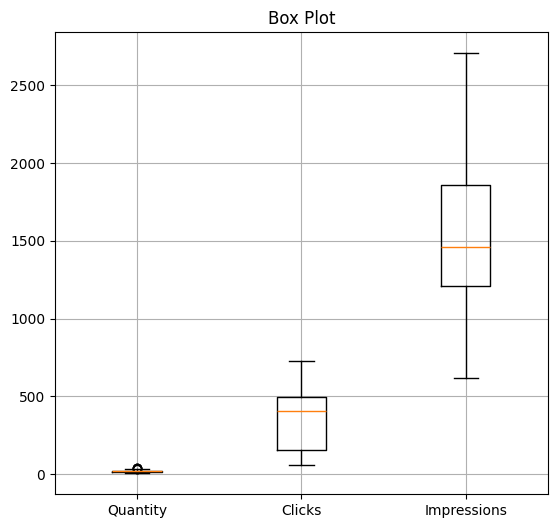

In [7]:
input_file = 'Merged_product.xlsx'
data = pd.read_excel(input_file)
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.boxplot([data[col] for col in ['Quantity', 'Clicks', 'Impressions']], labels=['Quantity', 'Clicks', 'Impressions'])
plt.title('Box Plot')
plt.grid(True)
plt.show()

------------------------------------------

Analyze Outliers. 

In [8]:
def find_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data < lower_bound) | (data > upper_bound)]
quantity_outliers = find_outliers_iqr(data['Quantity'])
clicks_outliers = find_outliers_iqr(data['Clicks'])
impressions_outliers = find_outliers_iqr(data['Impressions'])
print("Quantity Outliers:\n", quantity_outliers)
print("\nClicks Outliers:\n", clicks_outliers)
print("\nImpressions Outliers:\n", impressions_outliers)


Quantity Outliers:
 4      33
9      38
78     38
113    32
142    36
Name: Quantity, dtype: int64

Clicks Outliers:
 Series([], Name: Clicks, dtype: int64)

Impressions Outliers:
 Series([], Name: Impressions, dtype: int64)


Here we have found 5 outliers of the Quantity, but Clicks and Impressions does not have any outliers

--------------------------------

Outliers replacement

In [9]:
file_path = 'Merged_product.xlsx'
df = pd.read_excel(file_path)
def impute_outliers_97th_percentile(series):
    q1, q3 = series.quantile([0.25, 0.75])
    IQR = q3 - q1
    lower_bound, upper_bound = q1 - 1.5 * IQR, q3 + 1.5 * IQR
    percentile_95_value = series.quantile(0.97)
    return series.apply(lambda x: percentile_95_value if x < lower_bound or x > upper_bound else x)
df['modified_Quantity'] = impute_outliers_97th_percentile(df['Quantity'])
output_file_path = 'product.xlsx'
df.to_excel(output_file_path, index=False)
output_file_path

'product.xlsx'

Here we replace the outliers with 97th percentile

-------------------------------------------------

Quantity before Removing Outliers vs Quantity after Removing Outliers

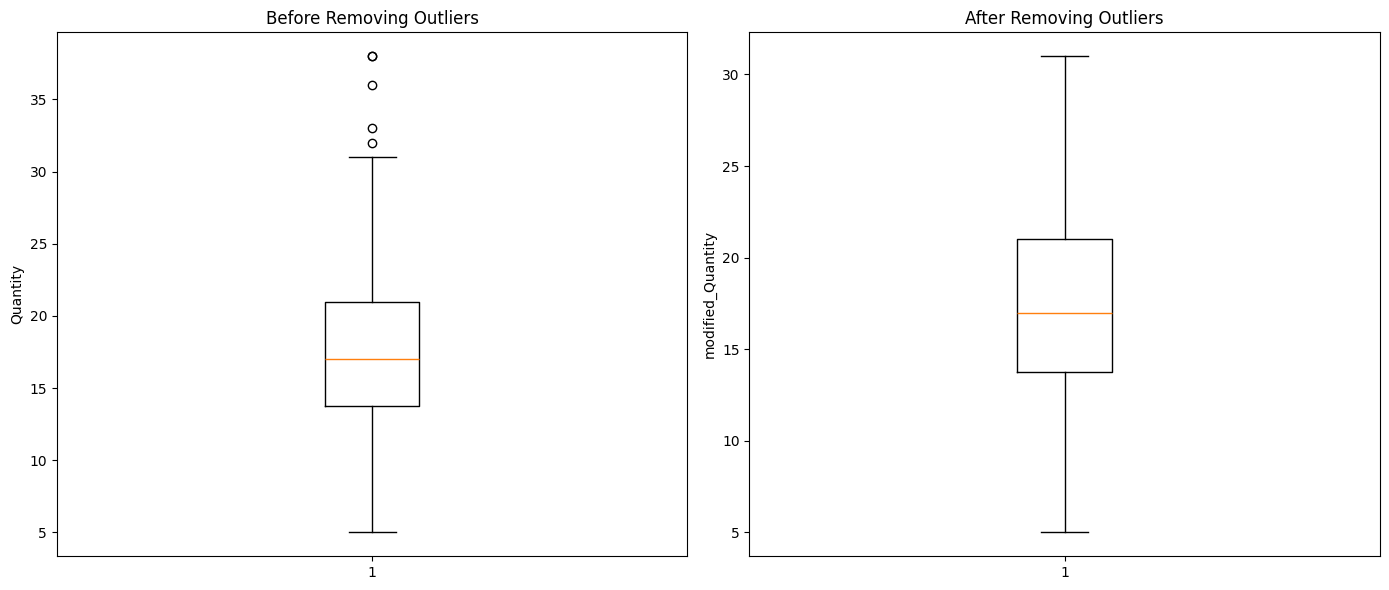

In [10]:
input_file = 'Merged_product.xlsx'
data = pd.read_excel(input_file)
modified_input_file = 'product.xlsx'
modified_data_ = pd.read_excel(modified_input_file)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].boxplot(data['Quantity'])
axes[0].set_title('Before Removing Outliers')
axes[0].set_ylabel('Quantity')
axes[1].boxplot(modified_data_['modified_Quantity'])
axes[1].set_title('After Removing Outliers')
axes[1].set_ylabel('modified_Quantity')
plt.tight_layout()
plt.show()

---------------------------

Feature Engineering on Sales Data

Extract Day, month and year

In [11]:
modified_input_file = 'product.xlsx'
data = pd.read_excel(modified_input_file)
data['Day Index'] = pd.to_datetime(data['Day Index'])
data['Year'] = data['Day Index'].dt.to_period('M')
data['Month'] = data['Day Index'].dt.strftime('%B')
data['Day'] = data['Day Index'].dt.day_name()
data['modified_Quantity'] = data['modified_Quantity'].fillna(data['modified_Quantity'].median())

Log Trasformation

In [12]:
data['log_Quantity'] = np.log(data['modified_Quantity'] + 1)
data['log_Clicks'] = np.log(data['Clicks'] + 1)
data['log_Impressions'] = np.log(data['Impressions'] + 1)

Importing to another file

In [13]:
data = data[['Day Index', 'Year', 'Month', 'Day', 'Quantity', 'Clicks', 'Impressions', 
             'modified_Quantity', 'log_Quantity', 'log_Clicks', 'log_Impressions']]
output_file_path = 'product.xlsx'
data.to_excel(output_file_path, index=False)
data.head()

Day Index     Year     Month        Day  Quantity  Clicks  Impressions  \
0 2021-12-01  2021-12  December  Wednesday        14     445          620   
1 2021-12-02  2021-12  December   Thursday        10     433          890   
2 2021-12-03  2021-12  December     Friday        13     424          851   
3 2021-12-04  2021-12  December   Saturday        22     427          881   
4 2021-12-05  2021-12  December     Sunday        33     451          678   

   modified_Quantity  log_Quantity  log_Clicks  log_Impressions  
0              14.00      2.708050    6.100319         6.431331  
1              10.00      2.397895    6.073045         6.792344  
2              13.00      2.639057    6.052089         6.747587  
3              22.00      3.135494    6.059123         6.782192  
4              30.67      3.455370    6.113682         6.520621

---------------------------

linear regression Plot

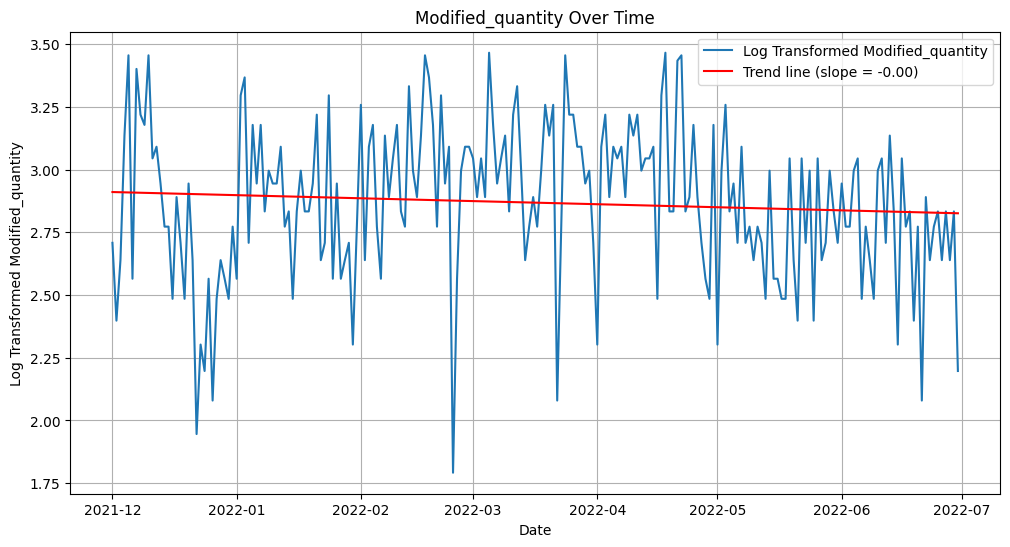

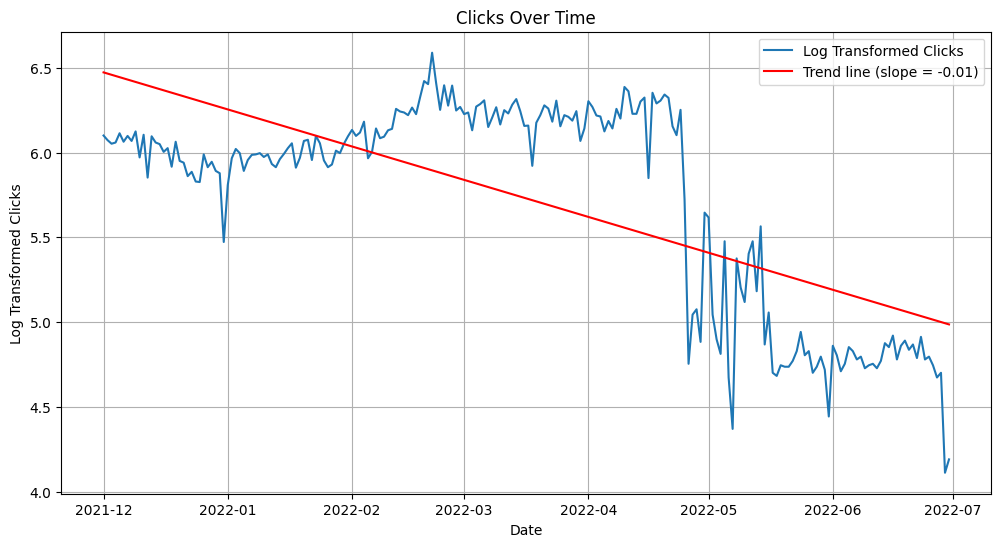

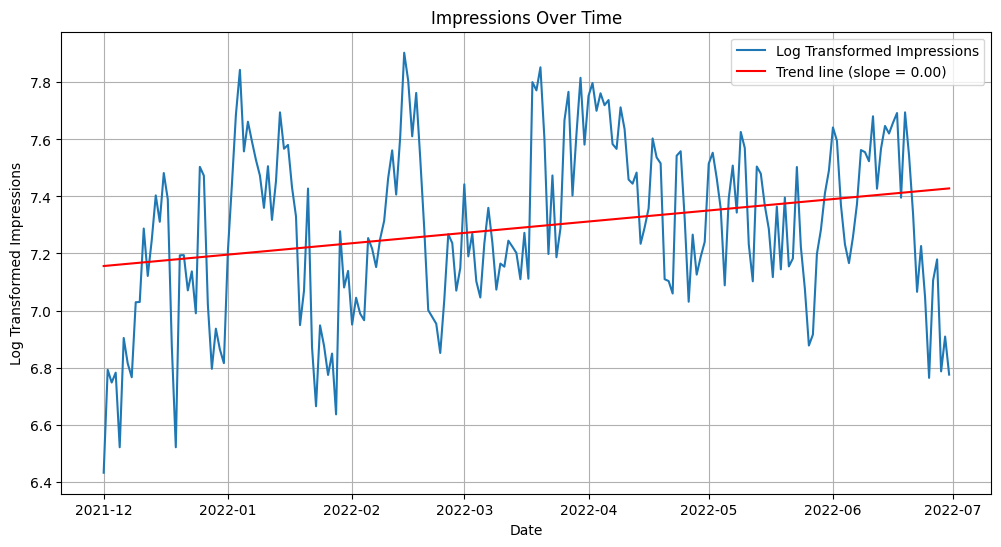

In [14]:
def plot(data, column, title, ylabel):
    data[f'log_{column}'] = np.log1p(data[column])
    transformed_column = f'log_{column}'
    x = np.arange(len(data))
    y = data[transformed_column].values
    slope, intercept, *_ = linregress(x, y)
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=data, x=data.index, y=transformed_column, label=f'Log Transformed {column.capitalize()}')
    plt.plot(data.index, intercept + slope * x, 'r', label=f'Trend line (slope = {slope:.2f})')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()
modified_data_['Day Index'] = pd.to_datetime(modified_data_['Day Index'])
modified_data_.set_index('Day Index', inplace=True)
numerical_columns = ['modified_Quantity', 'Clicks', 'Impressions']
for column in numerical_columns:
    plot(modified_data_, column, f'{column.capitalize()} Over Time', f'Log Transformed {column.capitalize()}')

-----

Correlation matrix

Correlation Analysis of Sales Data

The correlation matrix for Quantity, Clicks, and Impressions was computed to understand the relationships between these variables. The matrix highlights how these metrics are interrelated, providing insights into potential dependencies or associations within the data.

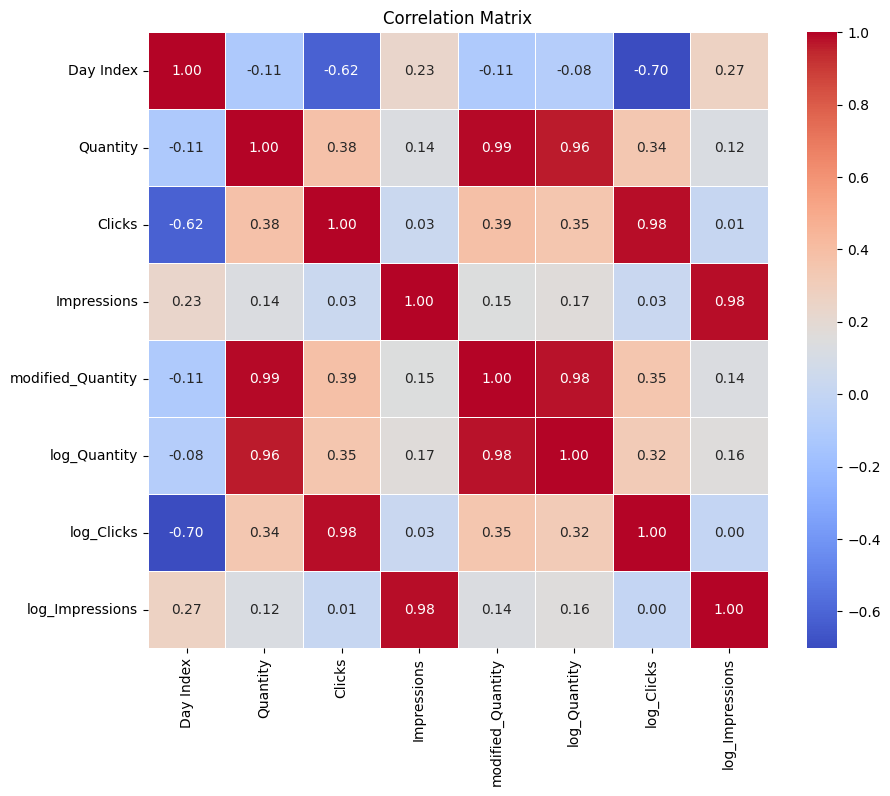

In [15]:
def calculate_and_plot_correlation_matrix(file_path):
    data = pd.read_excel(file_path)
    data['Day Index'] = pd.to_numeric(data['Day Index'], errors='coerce')
    numeric_data = data.select_dtypes(include=[float, int])
    correlation_matrix = numeric_data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Correlation Matrix')
    plt.show()
file_path = 'product.xlsx'
calculate_and_plot_correlation_matrix(file_path)

The correlation matrix reveals that higher engagement (Clicks) moderately increases sales (Quantity), while user engagement (Clicks) notably decreases over time

------

How the Clicks and Impressions affects the Quantity 

Click over Quantity

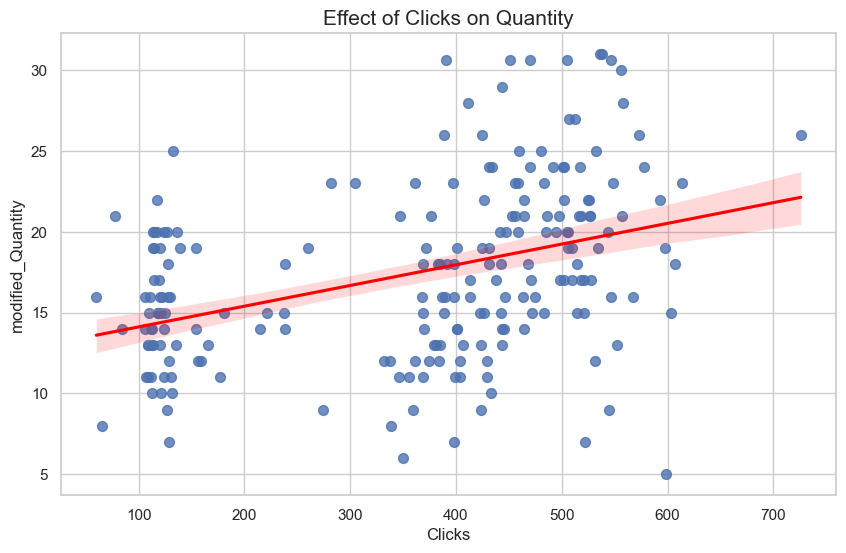

In [16]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.regplot(x='Clicks', y='modified_Quantity', data=data, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title('Effect of Clicks on Quantity', fontsize=15)
plt.xlabel('Clicks', fontsize=12)
plt.ylabel('modified_Quantity', fontsize=12)
plt.show()

Impressions over Quantity

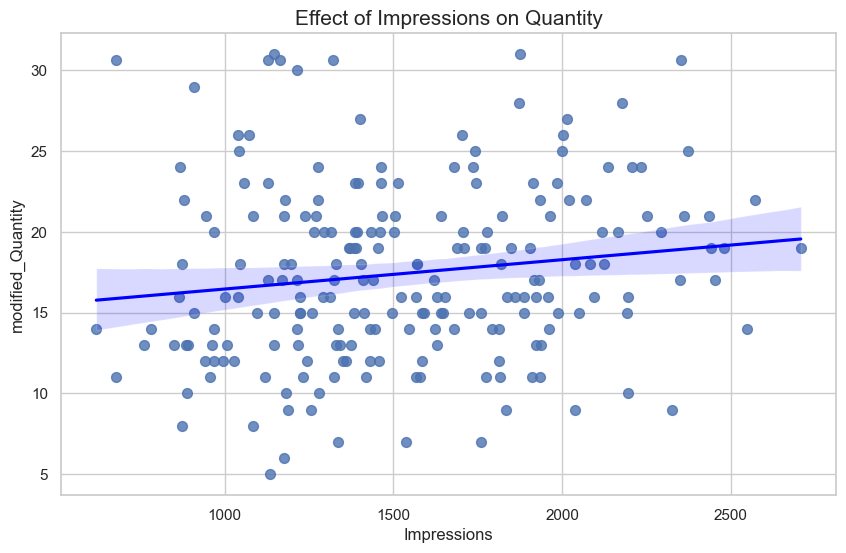

In [17]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Impressions', y='modified_Quantity', data=data, scatter_kws={'s':50}, line_kws={'color':'blue'})
plt.title('Effect of Impressions on Quantity', fontsize=15)
plt.xlabel('Impressions', fontsize=12)
plt.ylabel('modified_Quantity', fontsize=12)
plt.show()

Impressions vs clicks

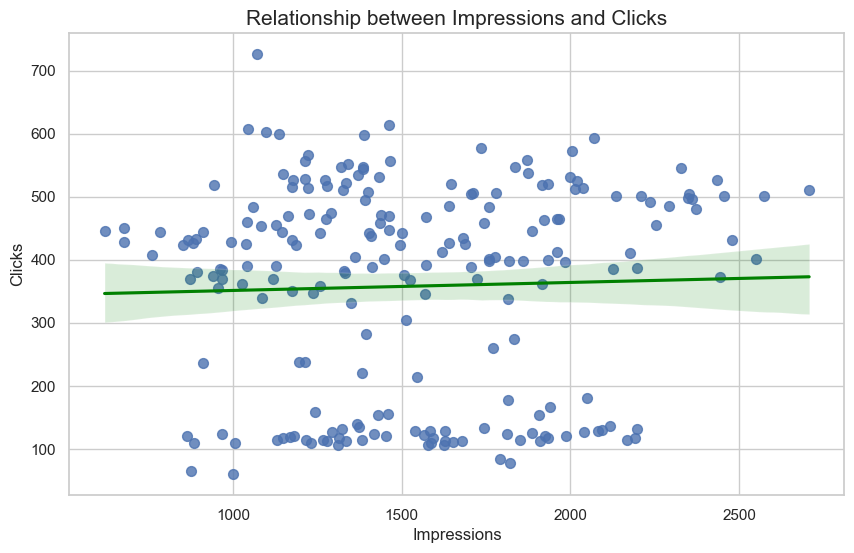

In [18]:
plt.figure(figsize=(10, 6))
sns.regplot(x='Impressions', y='Clicks', data=data, scatter_kws={'s':50}, line_kws={'color':'green'})
plt.title('Relationship between Impressions and Clicks', fontsize=15)
plt.xlabel('Impressions', fontsize=12)
plt.ylabel('Clicks', fontsize=12)
plt.show()

-----------------------------------

Visualization

In [19]:
input_file = 'product.xlsx'
data = pd.read_excel(input_file)

Day Wise Quantity

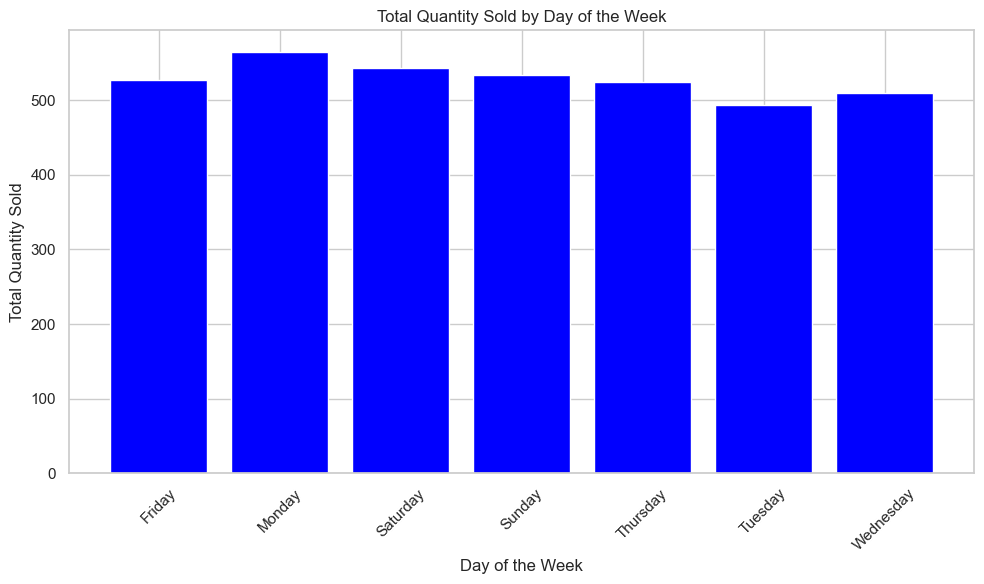

In [20]:
def plot_quantity_by_day(merged_df):
    merged_df['Day of Week'] = pd.to_datetime(merged_df['Day Index']).dt.day_name()
    quantity_by_day = merged_df.groupby('Day of Week')['modified_Quantity'].sum()
    plt.figure(figsize=(10, 6))
    plt.bar(quantity_by_day.index, quantity_by_day.values, color='blue')
    plt.xlabel('Day of the Week')
    plt.ylabel('Total Quantity Sold')
    plt.title('Total Quantity Sold by Day of the Week')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_quantity_by_day(data)

According to the plot we can see that Monday have high sales

--------------------------------------------

Day Wise Clicks

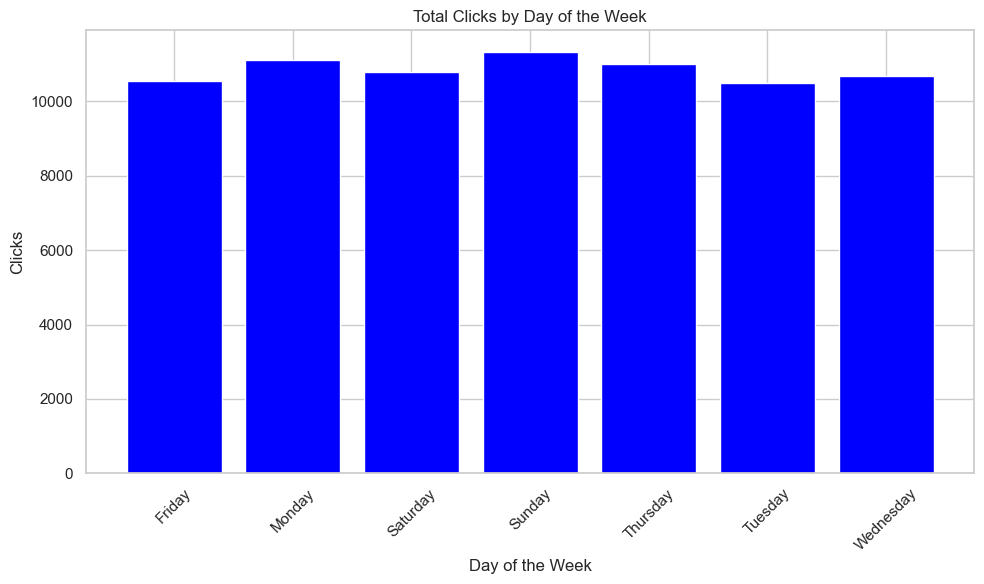

In [21]:
def plot_Clicks_by_day(merged_df):
    merged_df['Day of Week'] = pd.to_datetime(merged_df['Day Index']).dt.day_name()
    Clicks_by_day = merged_df.groupby('Day of Week')['Clicks'].sum()
    plt.figure(figsize=(10, 6))
    plt.bar(Clicks_by_day.index, Clicks_by_day.values, color='blue')
    plt.xlabel('Day of the Week')
    plt.ylabel('Clicks')
    plt.title('Total Clicks by Day of the Week')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_Clicks_by_day(data)

According to the plot we can see that Sunday have highest Clicks

-------------------------

Day Wise Impressions

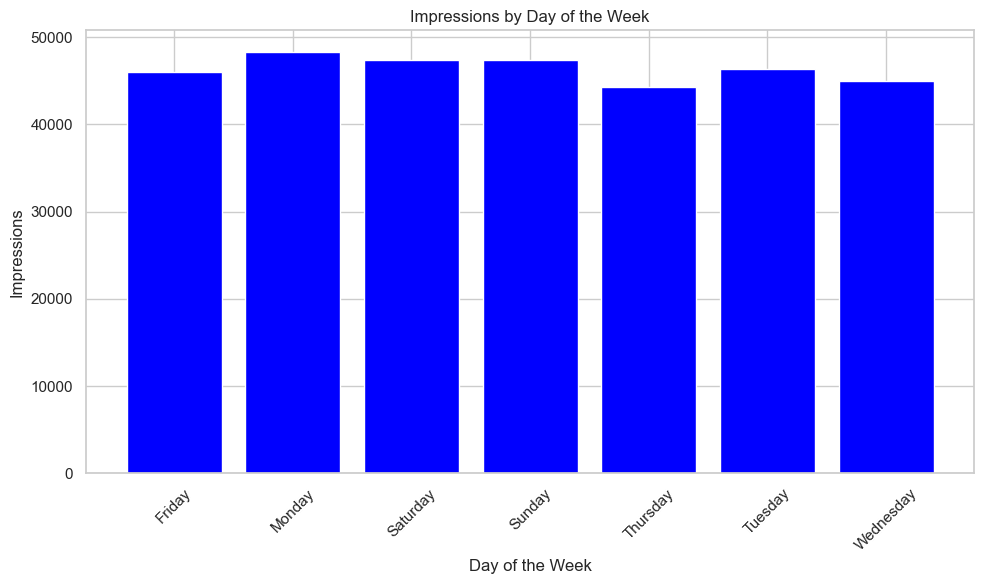

In [22]:
def plot_Impressions_by_day(merged_df):
    merged_df['Day of Week'] = pd.to_datetime(merged_df['Day Index']).dt.day_name()
    Impressions_by_day = merged_df.groupby('Day of Week')['Impressions'].sum()
    plt.figure(figsize=(10, 6))
    plt.bar(Impressions_by_day.index, Impressions_by_day.values, color='blue')
    plt.xlabel('Day of the Week')
    plt.ylabel('Impressions')
    plt.title('Impressions by Day of the Week')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_Impressions_by_day(data)

According to the plot we can see that Monday have highest Impressions

---------------

Week wise Quantity

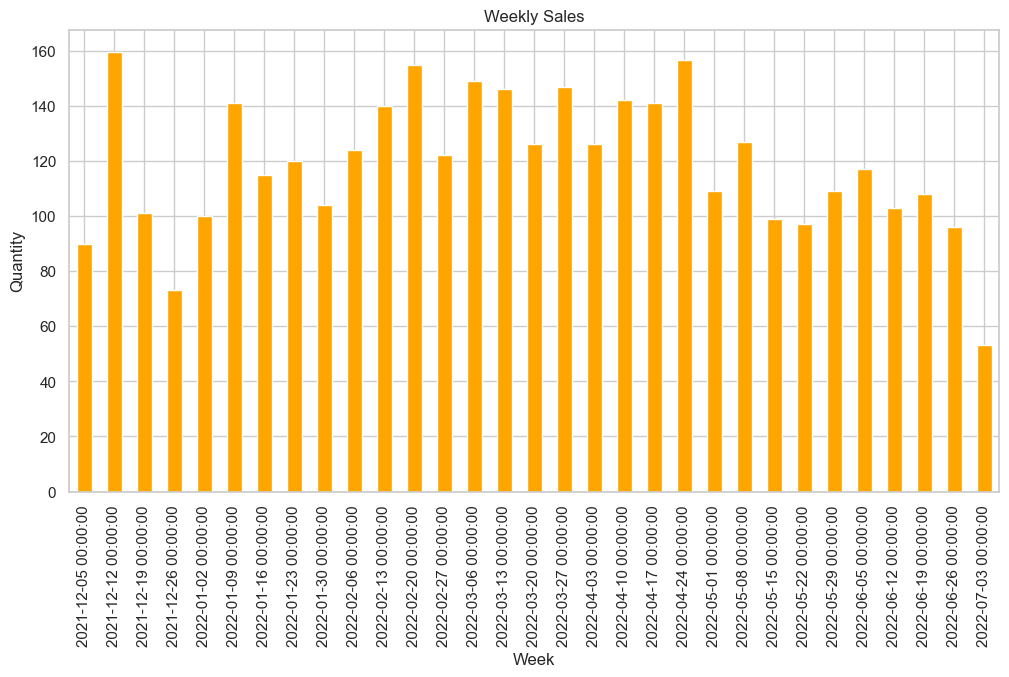

Weekly Sales: 2021-12-12 with 159.67 Quantity sold have the highest sales.


In [23]:
data['Day Index'] = pd.to_datetime(data['Day Index'])
data.set_index('Day Index', inplace=True)
plt.figure(figsize=(12, 6))
weekly_sales = data['modified_Quantity'].resample('W').sum()
weekly_sales.plot(kind='bar',color='orange')
plt.title('Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Quantity')
plt.show()
highest_week = weekly_sales.idxmax(), weekly_sales.max()
print(f"Weekly Sales: {highest_week[0].strftime('%Y-%m-%d')} with {highest_week[1]} Quantity sold have the highest sales.")

------------------------

Week wise Clicks

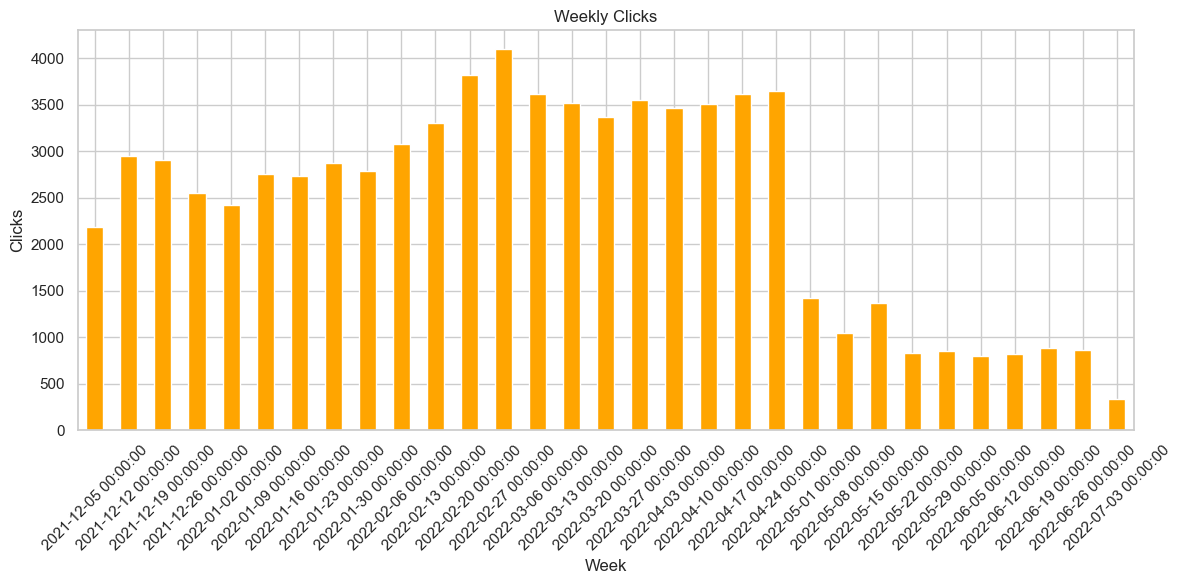

Week starting on 2022-02-27 had the highest clicks with 4095 clicks.


In [24]:
input_file = 'product.xlsx'
data = pd.read_excel(input_file)
data['Day Index'] = pd.to_datetime(data['Day Index'])
data.set_index('Day Index', inplace=True)
weekly_clicks = data['Clicks'].resample('W').sum()
plt.figure(figsize=(12, 6))
weekly_clicks.plot(kind='bar',color='orange')
plt.title('Weekly Clicks')
plt.xlabel('Week')
plt.ylabel('Clicks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
highest_week = weekly_clicks.idxmax(), weekly_clicks.max()
print(f"Week starting on {highest_week[0].strftime('%Y-%m-%d')} had the highest clicks with {highest_week[1]} clicks.")


--------------------------

Week wise Impressions

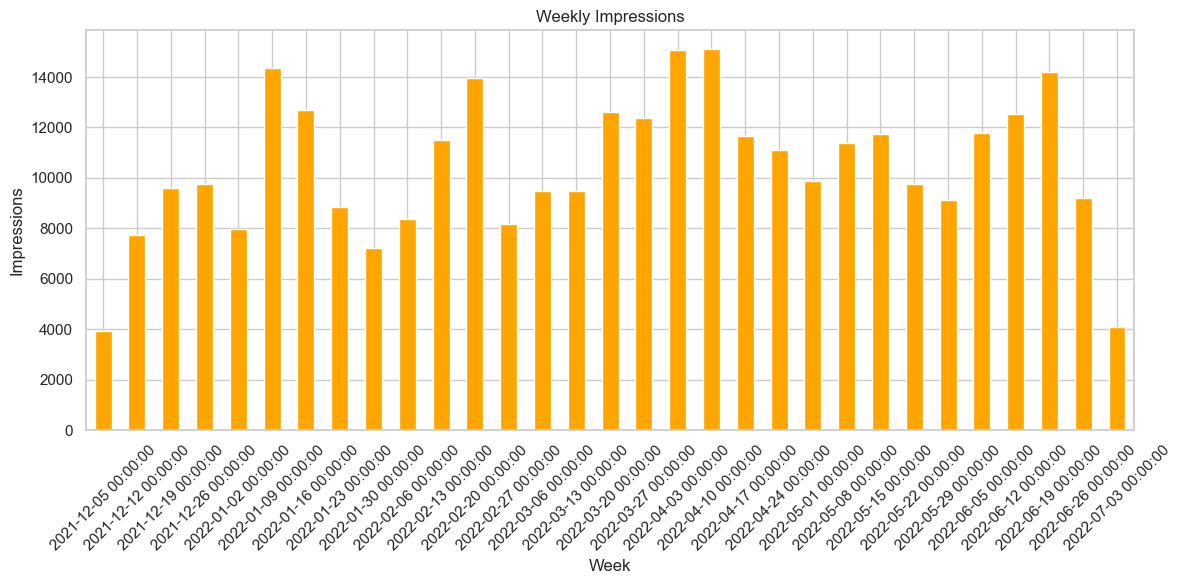

Week starting on 2022-04-10 had the highest Impressions with 15096 Impressions.


In [25]:
input_file = 'product.xlsx'
data = pd.read_excel(input_file)
data['Day Index'] = pd.to_datetime(data['Day Index'])
data.set_index('Day Index', inplace=True)
weekly_Impressions = data['Impressions'].resample('W').sum()
plt.figure(figsize=(12, 6))
weekly_Impressions.plot(kind='bar',color='orange')
plt.title('Weekly Impressions')
plt.xlabel('Week')
plt.ylabel('Impressions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
highest_week = weekly_Impressions.idxmax(), weekly_Impressions.max()
print(f"Week starting on {highest_week[0].strftime('%Y-%m-%d')} had the highest Impressions with {highest_week[1]} Impressions.")


---------------------------

Month wise Quantity

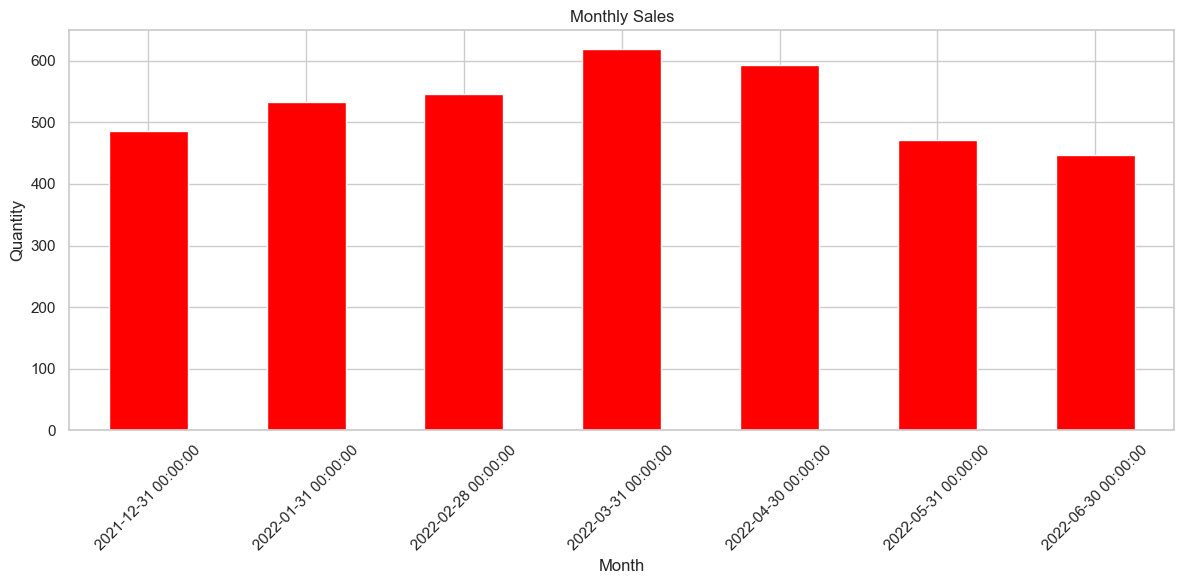

Month of March 2022 had the highest sales with 618.67 units sold.


In [26]:
input_file = 'product.xlsx'
data = pd.read_excel(input_file)
data['Day Index'] = pd.to_datetime(data['Day Index'])
data.set_index('Day Index', inplace=True)
monthly_sales = data['modified_Quantity'].resample('M').sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar',color='red')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
highest_month = monthly_sales.idxmax(), monthly_sales.max()
print(f"Month of {highest_month[0].strftime('%B %Y')} had the highest sales with {highest_month[1]} units sold.")

---------------------------------------

Month wise Clicks

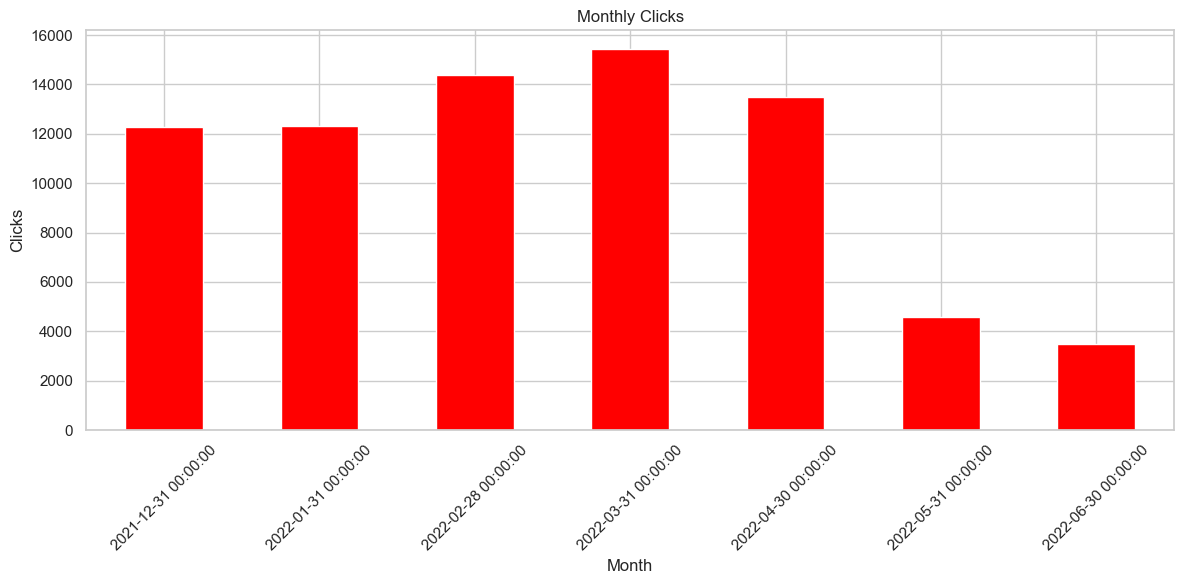

Month of March 2022 had the highest Clicks with 618.67 Clicks.


In [27]:
input_file = 'product.xlsx'
data = pd.read_excel(input_file)
data['Day Index'] = pd.to_datetime(data['Day Index'])
data.set_index('Day Index', inplace=True)
monthly_Clicks = data['Clicks'].resample('M').sum()
plt.figure(figsize=(12, 6))
monthly_Clicks.plot(kind='bar',color='red')
plt.title('Monthly Clicks')
plt.xlabel('Month')
plt.ylabel('Clicks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
highest_month = monthly_Clicks.idxmax(), monthly_sales.max()
print(f"Month of {highest_month[0].strftime('%B %Y')} had the highest Clicks with {highest_month[1]} Clicks.")

-----------------------------

Month wise Impressions

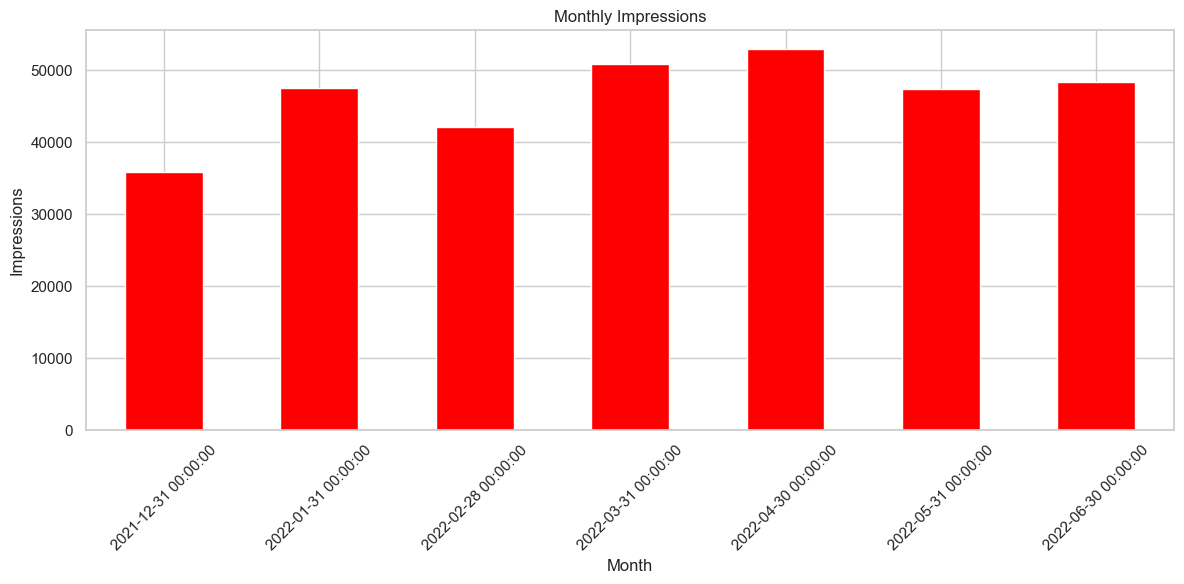

Month of April 2022 had the highest Impressions with 618.67 Impressions.


In [28]:
input_file = 'product.xlsx'
data = pd.read_excel(input_file)
data['Day Index'] = pd.to_datetime(data['Day Index'])
data.set_index('Day Index', inplace=True)
monthly_Impressions = data['Impressions'].resample('M').sum()
plt.figure(figsize=(12, 6))
monthly_Impressions.plot(kind='bar',color='red')
plt.title('Monthly Impressions')
plt.xlabel('Month')
plt.ylabel('Impressions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
highest_month = monthly_Impressions.idxmax(), monthly_sales.max()
print(f"Month of {highest_month[0].strftime('%B %Y')} had the highest Impressions with {highest_month[1]} Impressions.")

----------------------------------

Week days vs Weekend Quantity

Week Part Sales Data:
Week Part
Weekday    2618.68
Weekend    1076.67
Name: modified_Quantity, dtype: float64


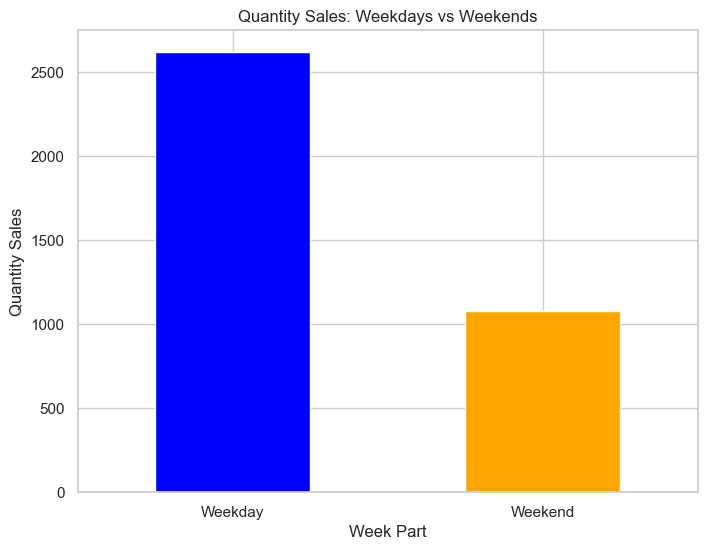

In [29]:
input_file = 'product.xlsx'
data = pd.read_excel(input_file)
data['Day Index'] = pd.to_datetime(data['Day Index'])
data['Day of Week'] = data['Day Index'].dt.dayofweek
data['Week Part'] = data['Day of Week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')
week_part_sales = data.groupby('Week Part')['modified_Quantity'].sum().reindex(['Weekday', 'Weekend'])
print("Week Part Sales Data:")
print(week_part_sales)
plt.figure(figsize=(8, 6))
week_part_sales.plot(kind='bar', color=['blue', 'orange'])
plt.title('Quantity Sales: Weekdays vs Weekends')
plt.xlabel('Week Part')
plt.ylabel('Quantity Sales')
plt.xticks(rotation=0)
plt.show()

Here we can see that Quantity Sales on weekdays is greater than Quantity Sales of weekend

----------------------------------------

Week days vs Weekend Clicks

Week Part Clicks Data:
Week Part
Weekday    53822
Weekend    22117
Name: Clicks, dtype: int64


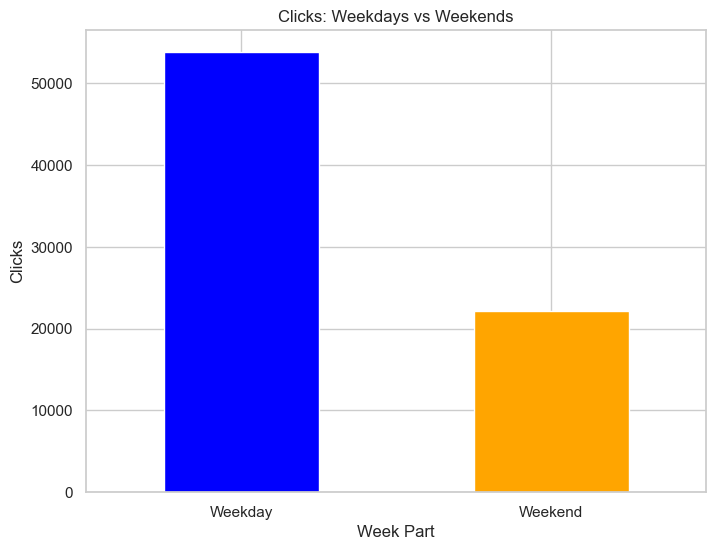

In [30]:
input_file = 'product.xlsx'
data = pd.read_excel(input_file)
data['Day Index'] = pd.to_datetime(data['Day Index'])
data['Day of Week'] = data['Day Index'].dt.dayofweek
data['Week Part'] = data['Day of Week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')
week_part_Clicks = data.groupby('Week Part')['Clicks'].sum().reindex(['Weekday', 'Weekend'])
print("Week Part Clicks Data:")
print(week_part_Clicks)
plt.figure(figsize=(8, 6))
week_part_Clicks.plot(kind='bar', color=['blue', 'orange'])
plt.title('Clicks: Weekdays vs Weekends')
plt.xlabel('Week Part')
plt.ylabel('Clicks')
plt.xticks(rotation=0)
plt.show()

Here we can see that Clicks of weekdays is greater than Clicks of weekend

--------------------------------

Week days vs Weekend Impressions

Week Part Impressions Data:
Week Part
Weekday    229914
Weekend     94807
Name: Impressions, dtype: int64


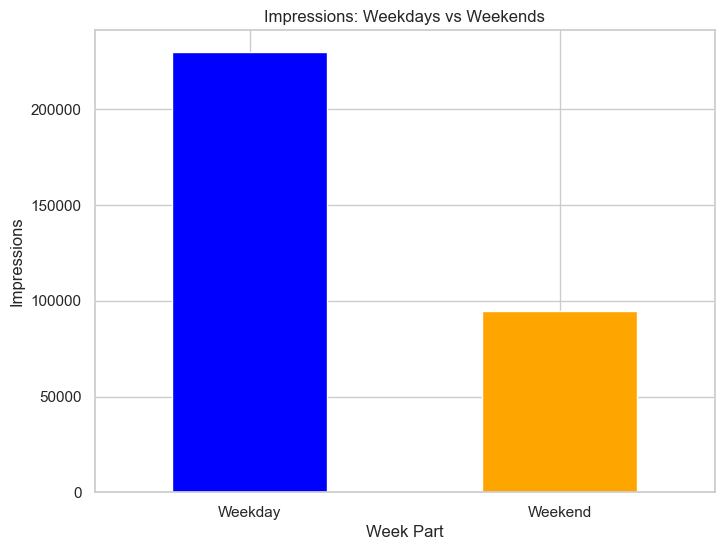

In [31]:
input_file = 'product.xlsx'
data = pd.read_excel(input_file)
data['Day Index'] = pd.to_datetime(data['Day Index'])
data['Day of Week'] = data['Day Index'].dt.dayofweek
data['Week Part'] = data['Day of Week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')
week_part_Impressions = data.groupby('Week Part')['Impressions'].sum().reindex(['Weekday', 'Weekend'])
print("Week Part Impressions Data:")
print(week_part_Impressions)
plt.figure(figsize=(8, 6))
week_part_Impressions.plot(kind='bar', color=['blue', 'orange'])
plt.title('Impressions: Weekdays vs Weekends')
plt.xlabel('Week Part')
plt.ylabel('Impressions')
plt.xticks(rotation=0)
plt.show()

Here we can see that Impressions of weekdays is greater than Impressions of weekend

-----------------------------

Regression Analysis of Google Clicks vs Sales Quantity

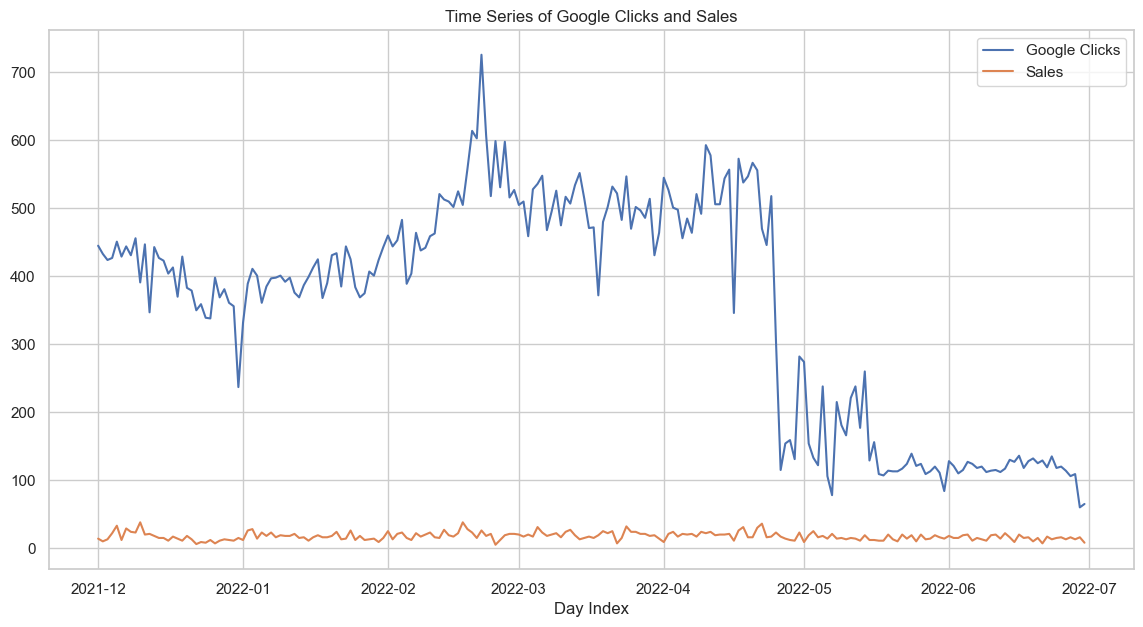

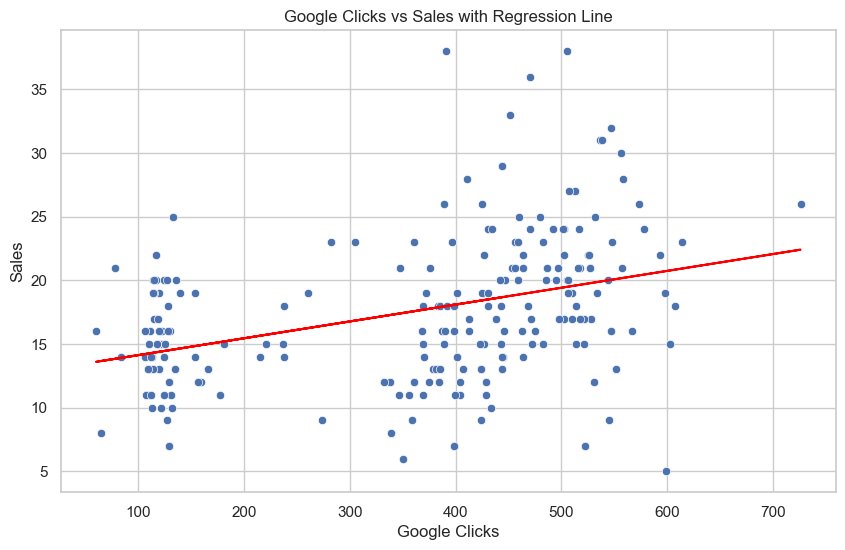

Correlation: 0.38
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     34.59
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           1.59e-08
Time:                        14:58:35   Log-Likelihood:                -656.47
No. Observations:                 212   AIC:                             1317.
Df Residuals:                     210   BIC:                             1324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8017      0.887  

In [32]:
def analyze_google_clicks_effect(file_path):
    data = pd.read_excel(file_path, usecols=['Day Index', 'Clicks', 'Quantity'])
    data['Day Index'] = pd.to_datetime(data['Day Index'])
    data.sort_values('Day Index', inplace=True)
    plt.figure(figsize=(14, 7))
    plt.plot(data['Day Index'], data['Clicks'], label='Google Clicks')
    plt.plot(data['Day Index'], data['Quantity'], label='Sales')
    plt.title('Time Series of Google Clicks and Sales')
    plt.xlabel('Day Index')
    plt.legend()
    plt.show()
    X, y = data['Clicks'].values.reshape(-1, 1), data['Quantity'].values
    model = LinearRegression().fit(X, y)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=data['Clicks'], y=data['Quantity'])
    plt.plot(data['Clicks'], model.predict(X), color='red')
    plt.title('Google Clicks vs Sales with Regression Line')
    plt.xlabel('Google Clicks')
    plt.ylabel('Sales')
    plt.show()
    print(f'Correlation: {data["Clicks"].corr(data["Quantity"]):.2f}')
    print(sm.OLS(y, sm.add_constant(X)).fit().summary())
analyze_google_clicks_effect(input_file)

------------------------------------------

Regression Analysis of Facebook Impressions vs Sales Quantity

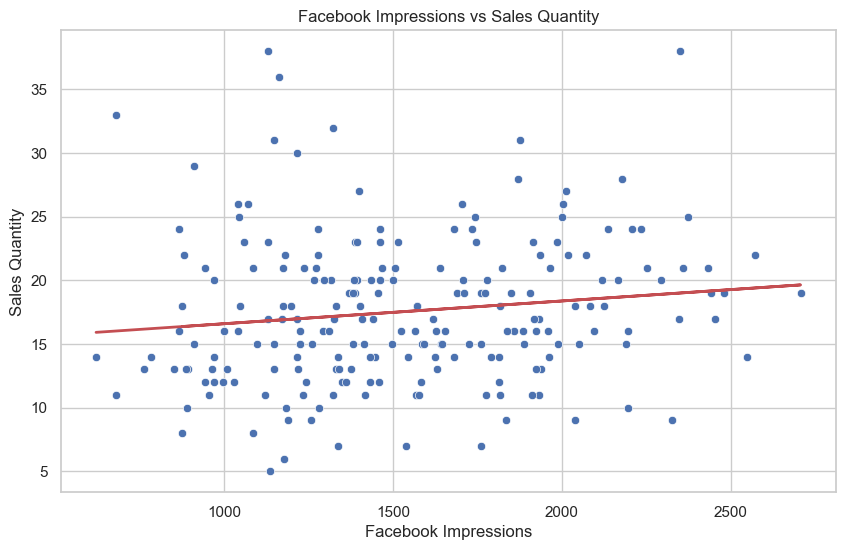

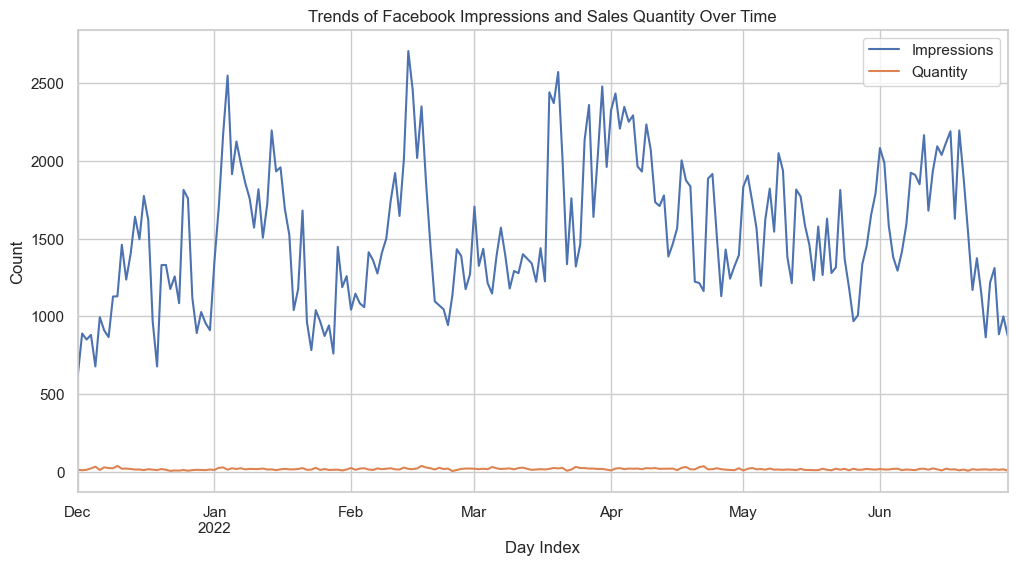

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     3.954
Date:                Fri, 12 Jul 2024   Prob (F-statistic):             0.0481
Time:                        14:58:35   Log-Likelihood:                -670.65
No. Observations:                 212   AIC:                             1345.
Df Residuals:                     210   BIC:                             1352.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          14.8063      1.432     10.343      

In [33]:
df = pd.read_excel('Merged_product.xlsx', usecols=['Day Index', 'Impressions', 'Quantity'])
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Impressions', y='Quantity', data=df)
X = sm.add_constant(df['Impressions'])
model = sm.OLS(df['Quantity'], X).fit()
plt.plot(df['Impressions'], model.predict(X), 'r-', linewidth=2)
plt.title('Facebook Impressions vs Sales Quantity')
plt.xlabel('Facebook Impressions')
plt.ylabel('Sales Quantity')
plt.show()
df['Day Index'] = pd.to_datetime(df['Day Index'])
df.set_index('Day Index')[['Impressions', 'Quantity']].plot(figsize=(12, 6), title='Trends of Facebook Impressions and Sales Quantity Over Time')
plt.ylabel('Count')
plt.show()
print(model.summary())

-------------------------------

Regression Analysis with Lagged Variables

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     13.36
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           5.27e-08
Time:                        14:58:35   Log-Likelihood:                -651.10
No. Observations:                 211   AIC:                             1310.
Df Residuals:                     207   BIC:                             1324.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.9672      1.717  

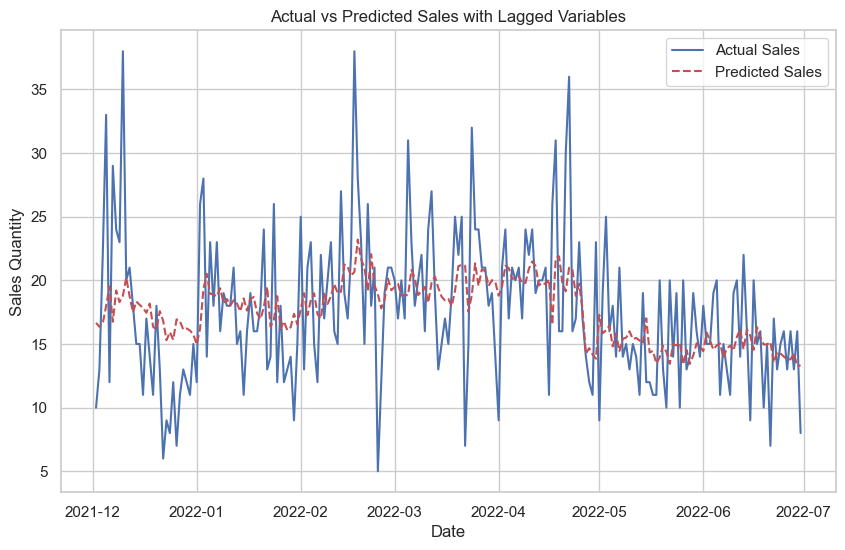

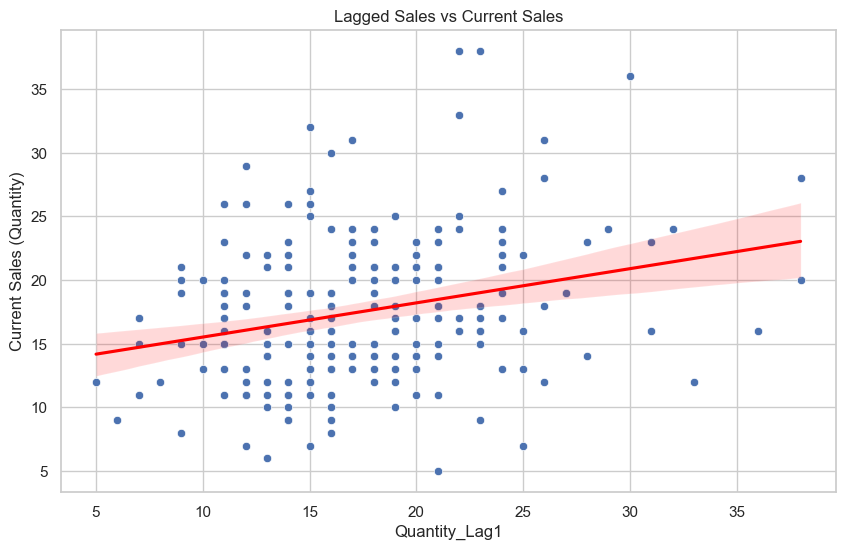

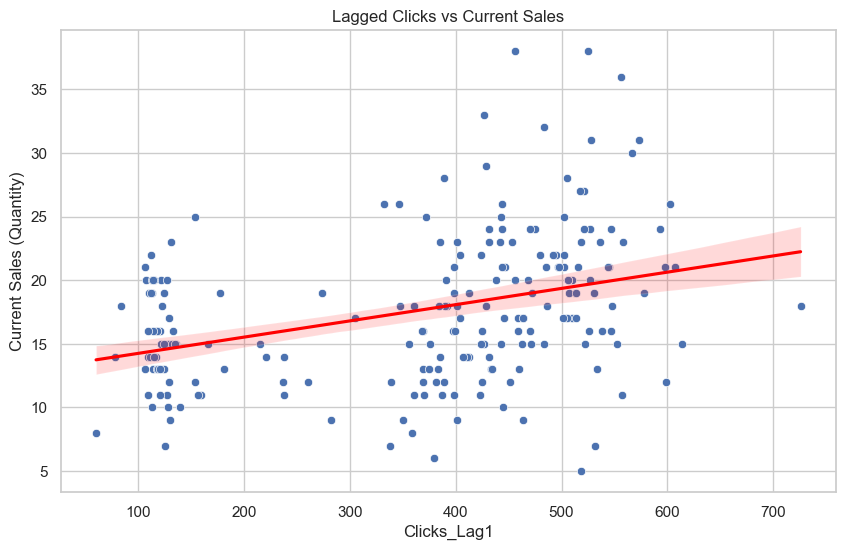

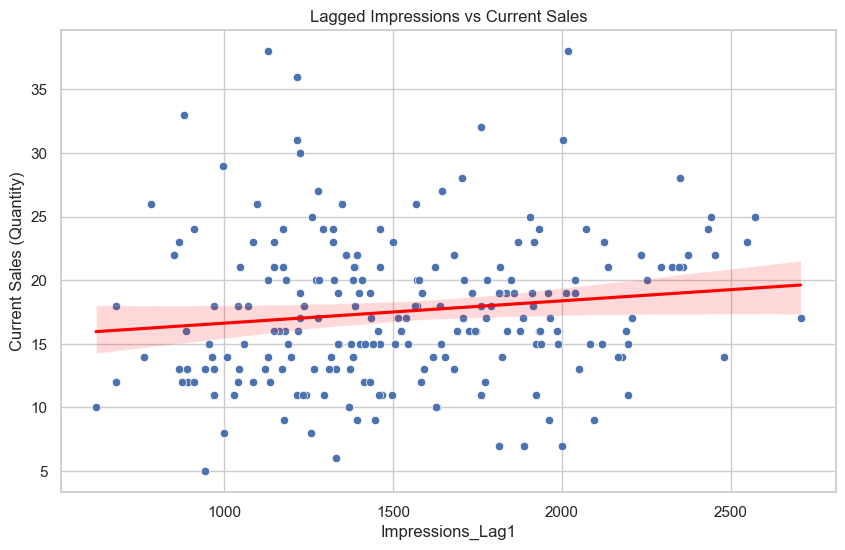

In [34]:
df = pd.read_excel('product.xlsx', usecols=['Day Index', 'Quantity', 'Clicks', 'Impressions'])
df[['Quantity_Lag1', 'Clicks_Lag1', 'Impressions_Lag1']] = df[['Quantity', 'Clicks', 'Impressions']].shift(1)
df.dropna(inplace=True)
X = sm.add_constant(df[['Quantity_Lag1', 'Clicks_Lag1', 'Impressions_Lag1']])
model = sm.OLS(df['Quantity'], X).fit()
predictions = model.predict(X)
print(model.summary())
plt.figure(figsize=(10, 6))
plt.plot(df['Day Index'], df['Quantity'], label='Actual Sales')
plt.plot(df['Day Index'], predictions, 'r--', label='Predicted Sales')
plt.title('Actual vs Predicted Sales with Lagged Variables')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()
for var, title in zip(['Quantity_Lag1', 'Clicks_Lag1', 'Impressions_Lag1'], 
                      ['Lagged Sales vs Current Sales', 
                       'Lagged Clicks vs Current Sales', 
                       'Lagged Impressions vs Current Sales']):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df[var], y=df['Quantity'])
    sns.regplot(x=df[var], y=df['Quantity'], scatter=False, color='red')
    plt.title(title)
    plt.xlabel(var)
    plt.ylabel('Current Sales (Quantity)')
    plt.show()

---------------------------------------------

Time Series Analysis of Sales, Clicks, and Impressions

The time series data for Sales Quantity, Google Clicks, and Facebook Impressions were analyzed to observe trends and stationarity. Through visualizations and statistical tests (ADF and KPSS), it was found that the data exhibits varying degrees of trend and seasonality, with rolling statistics further highlighting these characteristics.

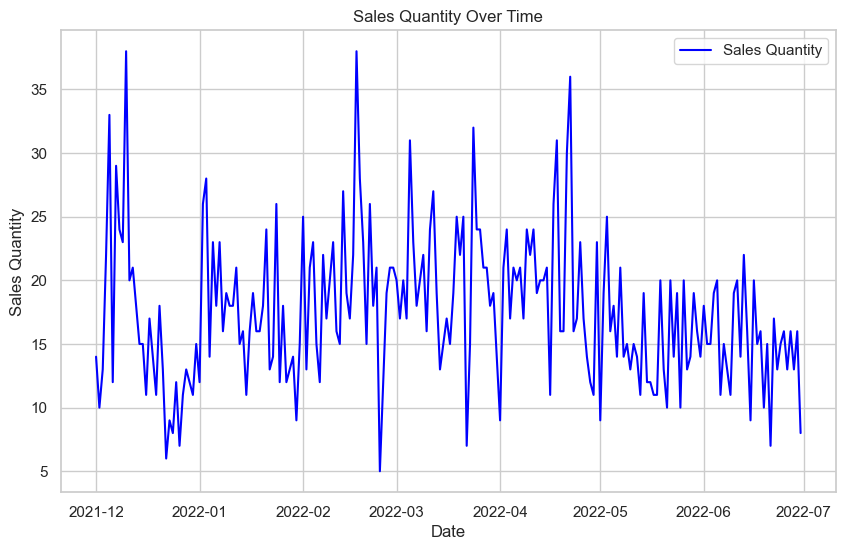

Sales Quantity ADF Test: Statistic: -4.445717448758575,
 p-value: 0.00024615679644112006,
 Critical Values: {'1%': -3.4621857592784546, '5%': -2.875537986778846, '10%': -2.574231080806213}

Sales Quantity KPSS Test: Statistic: 0.32262319685825785, 
 p-value: 0.1,
 Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}



C:\Users\sandi\AppData\Local\Temp\ipykernel_15856\4189800666.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(data[column_name], regression='c')


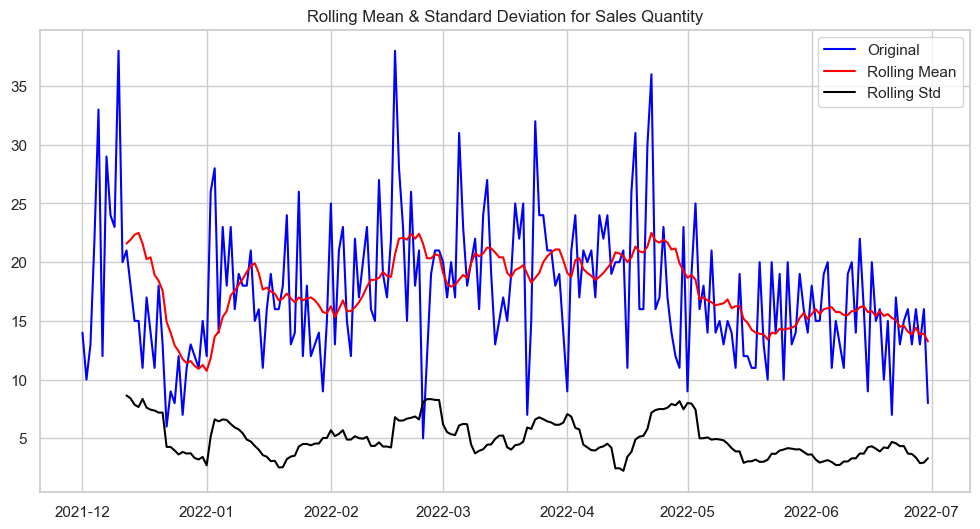

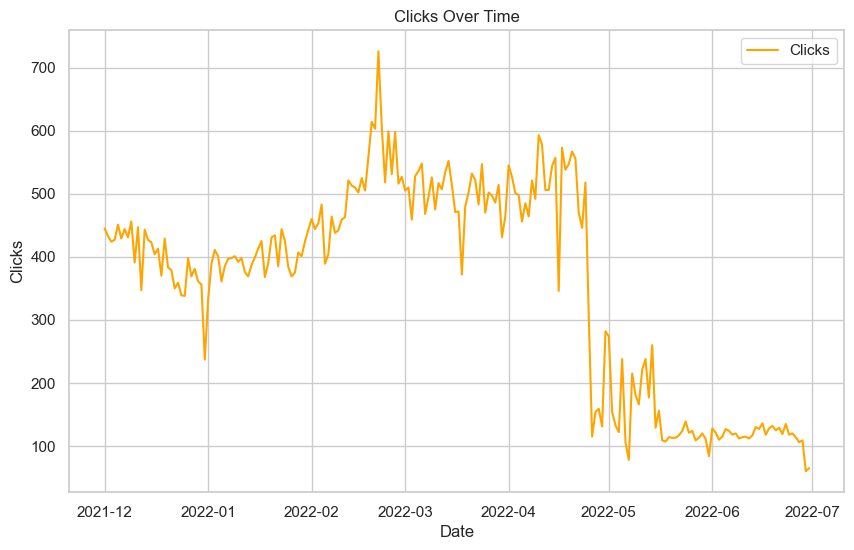

Clicks ADF Test: Statistic: -0.8705717270828215,
 p-value: 0.797509057499528,
 Critical Values: {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}

Clicks KPSS Test: Statistic: 1.1710453212394392, 
 p-value: 0.01,
 Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}



C:\Users\sandi\AppData\Local\Temp\ipykernel_15856\4189800666.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(data[column_name], regression='c')


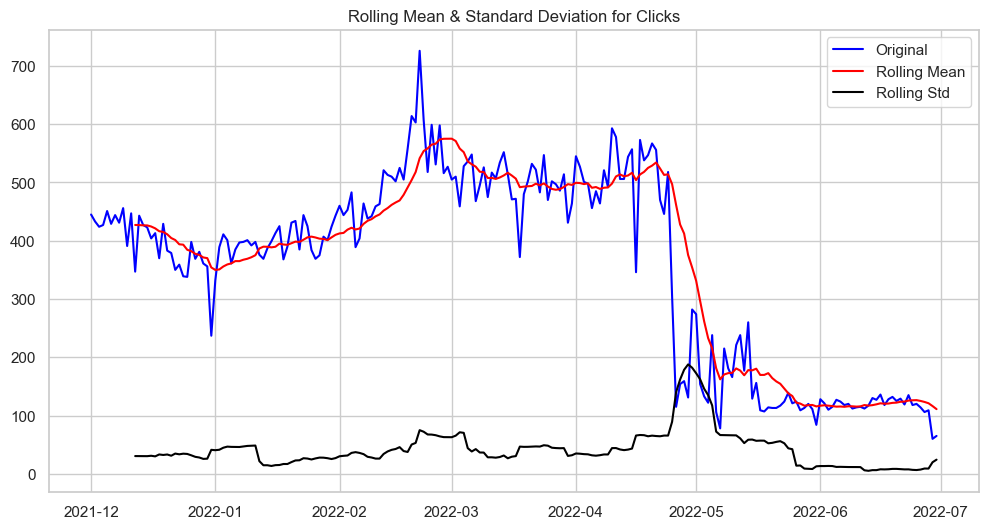

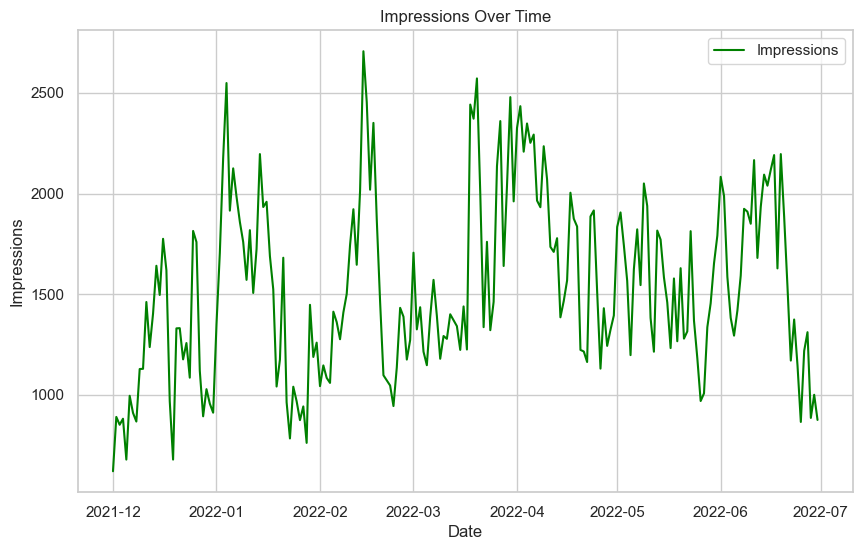

Impressions ADF Test: Statistic: -5.6962061101258685,
 p-value: 7.863580125889645e-07,
 Critical Values: {'1%': -3.46172743446274, '5%': -2.8753374677799957, '10%': -2.574124089081557}

Impressions KPSS Test: Statistic: 0.3518075100307243, 
 p-value: 0.09792779740054987,
 Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}



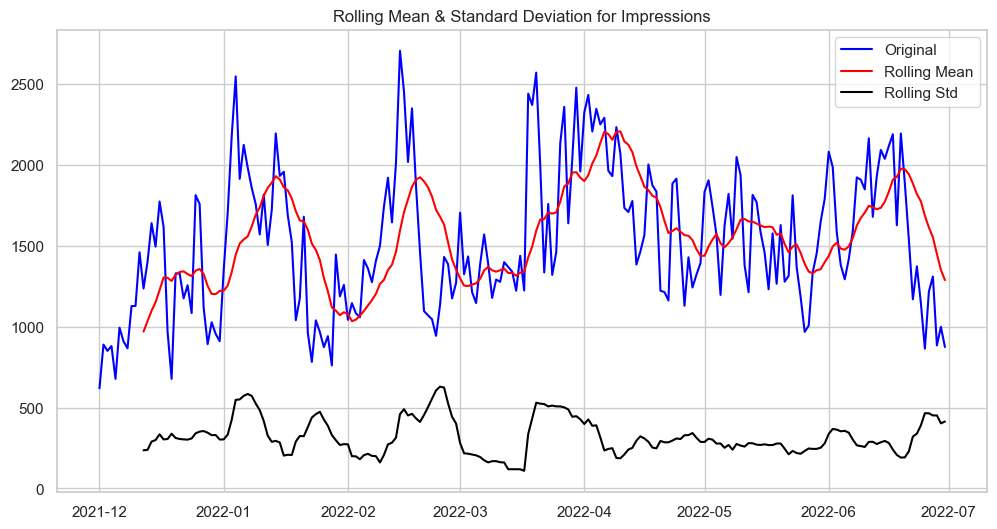

In [35]:
register_matplotlib_converters()
def analyze_time_series(data, column_name, label, color):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data[column_name], label=label, color=color)
    plt.title(f'{label} Over Time')
    plt.xlabel('Date')
    plt.ylabel(label)
    plt.legend()
    plt.show()
    adf_result = adfuller(data[column_name])
    print(f"{label} ADF Test: Statistic: {adf_result[0]},\n p-value: {adf_result[1]},\n Critical Values: {adf_result[4]}\n")
    kpss_result = kpss(data[column_name], regression='c')
    print(f"{label} KPSS Test: Statistic: {kpss_result[0]}, \n p-value: {kpss_result[1]},\n Critical Values: {kpss_result[3]}\n")
    plt.figure(figsize=(12, 6))
    plt.plot(data[column_name], label='Original', color='blue')
    plt.plot(data[column_name].rolling(window=12).mean(), label='Rolling Mean', color='red')
    plt.plot(data[column_name].rolling(window=12).std(), label='Rolling Std', color='black')
    plt.title(f'Rolling Mean & Standard Deviation for {label}')
    plt.legend()
    plt.show()
input_file = 'product.xlsx'
data = pd.read_excel(input_file)
data['Day Index'] = pd.to_datetime(data['Day Index'])
data.set_index('Day Index', inplace=True)
columns = ['Quantity', 'Clicks', 'Impressions']
colors = ['blue', 'orange', 'green']
for column, color in zip(columns, colors):
    analyze_time_series(data, column, column.replace("Quantity", "Sales Quantity"), color)

---------------------------

 Sales Quantity Over Time

Seasonality Test

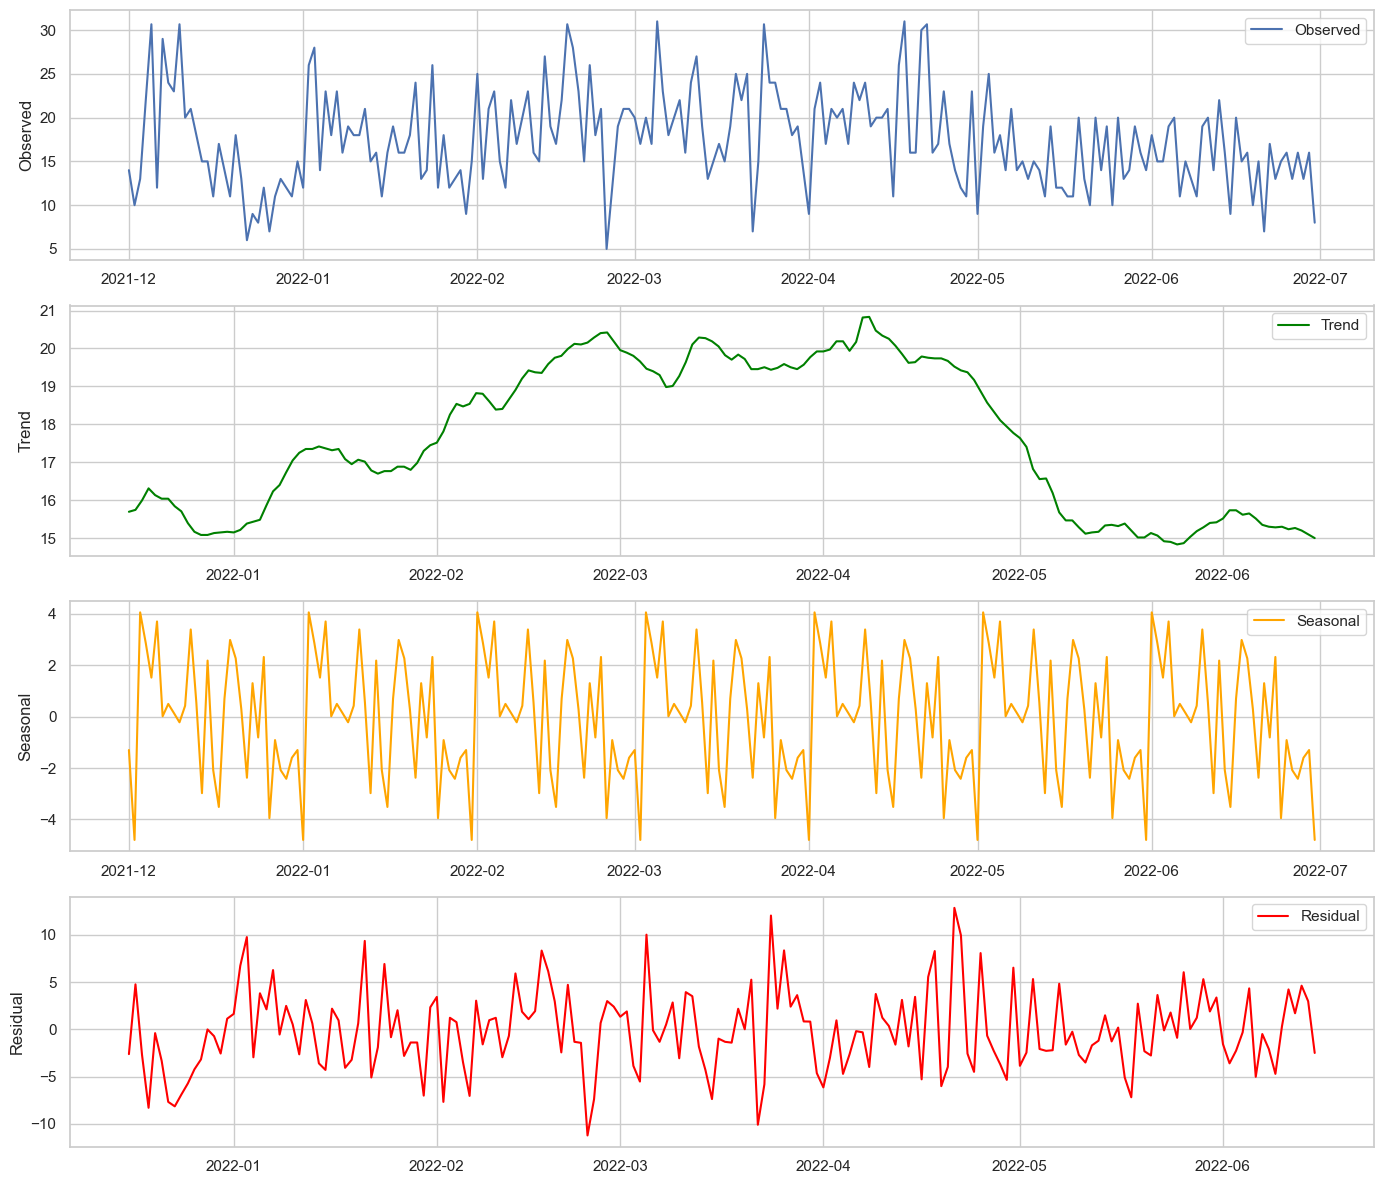

In [36]:
input_file = 'product.xlsx'
data = pd.read_excel(input_file)
data['Day Index'] = pd.to_datetime(data['Day Index'])
data.set_index('Day Index', inplace=True)
decomposition_sales = seasonal_decompose(data['modified_Quantity'], model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
ax1.plot(decomposition_sales.observed, label='Observed')
ax1.set_ylabel('Observed')
ax1.legend()
ax2.plot(decomposition_sales.trend, label='Trend', color='green')
ax2.set_ylabel('Trend')
ax2.legend()
ax3.plot(decomposition_sales.seasonal, label='Seasonal', color='orange')
ax3.set_ylabel('Seasonal')
ax3.legend()
ax4.plot(decomposition_sales.resid, label='Residual', color='red')
ax4.set_ylabel('Residual')
ax4.legend()
plt.tight_layout()
plt.show()

Clicks Quantity Over Time

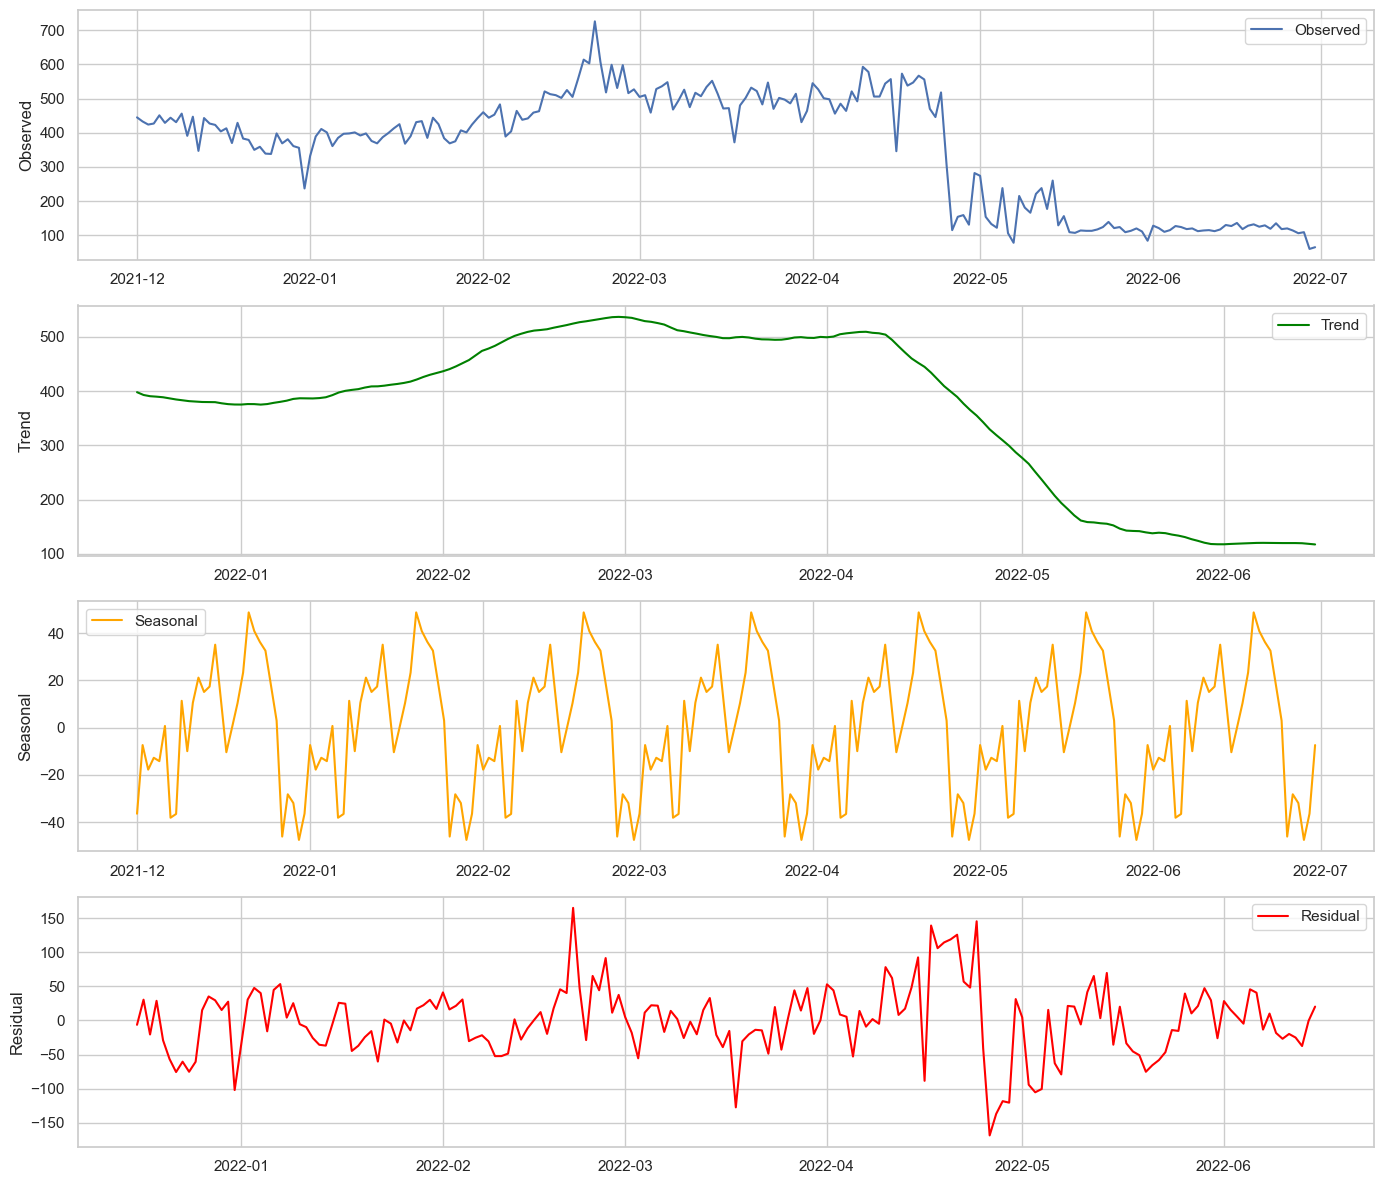

In [37]:
google_clicks = pd.read_excel('product.xlsx')
google_clicks['Day Index'] = pd.to_datetime(google_clicks['Day Index'])
google_clicks.set_index('Day Index', inplace=True)
decomposition_clicks = seasonal_decompose(google_clicks['Clicks'], model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
ax1.plot(decomposition_clicks.observed, label='Observed')
ax1.set_ylabel('Observed')
ax1.legend()
ax2.plot(decomposition_clicks.trend, label='Trend', color='green')
ax2.set_ylabel('Trend')
ax2.legend()
ax3.plot(decomposition_clicks.seasonal, label='Seasonal', color='orange')
ax3.set_ylabel('Seasonal')
ax3.legend()
ax4.plot(decomposition_clicks.resid, label='Residual', color='red')
ax4.set_ylabel('Residual')
ax4.legend()
plt.tight_layout()
plt.show()

Impressions Quantity Over Time

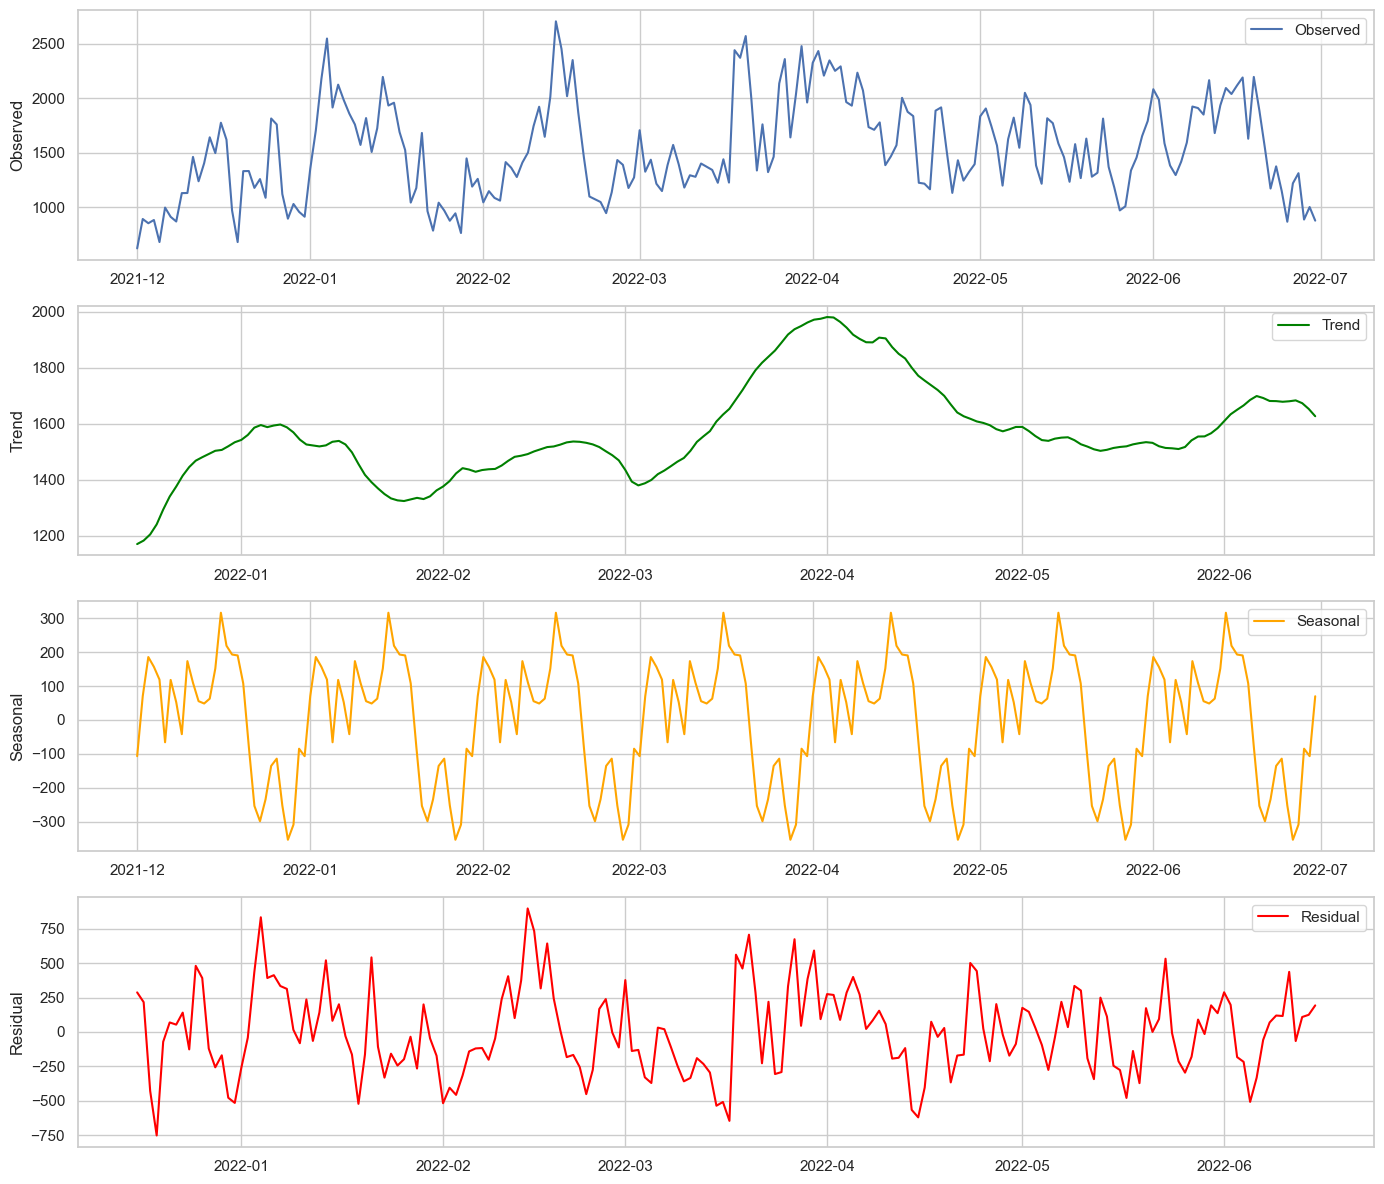

In [38]:
fb_impressions = pd.read_excel('product.xlsx')
fb_impressions['Day Index'] = pd.to_datetime(fb_impressions['Day Index'])
fb_impressions.set_index('Day Index', inplace=True)
decomposition_impressions = seasonal_decompose(fb_impressions['Impressions'], model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
ax1.plot(decomposition_impressions.observed, label='Observed')
ax1.set_ylabel('Observed')
ax1.legend()
ax2.plot(decomposition_impressions.trend, label='Trend', color='green')
ax2.set_ylabel('Trend')
ax2.legend()
ax3.plot(decomposition_impressions.seasonal, label='Seasonal', color='orange')
ax3.set_ylabel('Seasonal')
ax3.legend()
ax4.plot(decomposition_impressions.resid, label='Residual', color='red')
ax4.set_ylabel('Residual')
ax4.legend()
plt.tight_layout()
plt.show()

---------------------------

Stationarity check of the time series

ADF Plot

In [39]:
def load_data(data, sheet_name):
    return pd.read_excel(data, sheet_name=sheet_name)
def adf_test(timeseries, series_name):
    adf_statistic, p_value, *_ = adfuller(timeseries.dropna(), autolag='AIC')
    print(f"\nADF Test for {series_name}:\n ADF Statistic: {adf_statistic}\n p-value: {p_value}")
    print(f"{series_name} is {'stationary.' if p_value < 0.05 else 'non-stationary.'}\n")
def main():
    df = load_data('product.xlsx', 'Sheet1')
    for column in ['modified_Quantity','Clicks', 'Impressions']:
        adf_test(df[column], column)
if __name__ == "__main__":
    main()


ADF Test for modified_Quantity:
 ADF Statistic: -4.372460988868508
 p-value: 0.0003319752426367862
modified_Quantity is stationary.


ADF Test for Clicks:
 ADF Statistic: -0.8705717270828215
 p-value: 0.797509057499528
Clicks is non-stationary.


ADF Test for Impressions:
 ADF Statistic: -5.6962061101258685
 p-value: 7.863580125889645e-07
Impressions is stationary.



From ADF statistics we get to know that - 

Quantity is stationary, Clicks is non-stationary and Impressions is stationary.

-----------------------------------

make clicks stationary

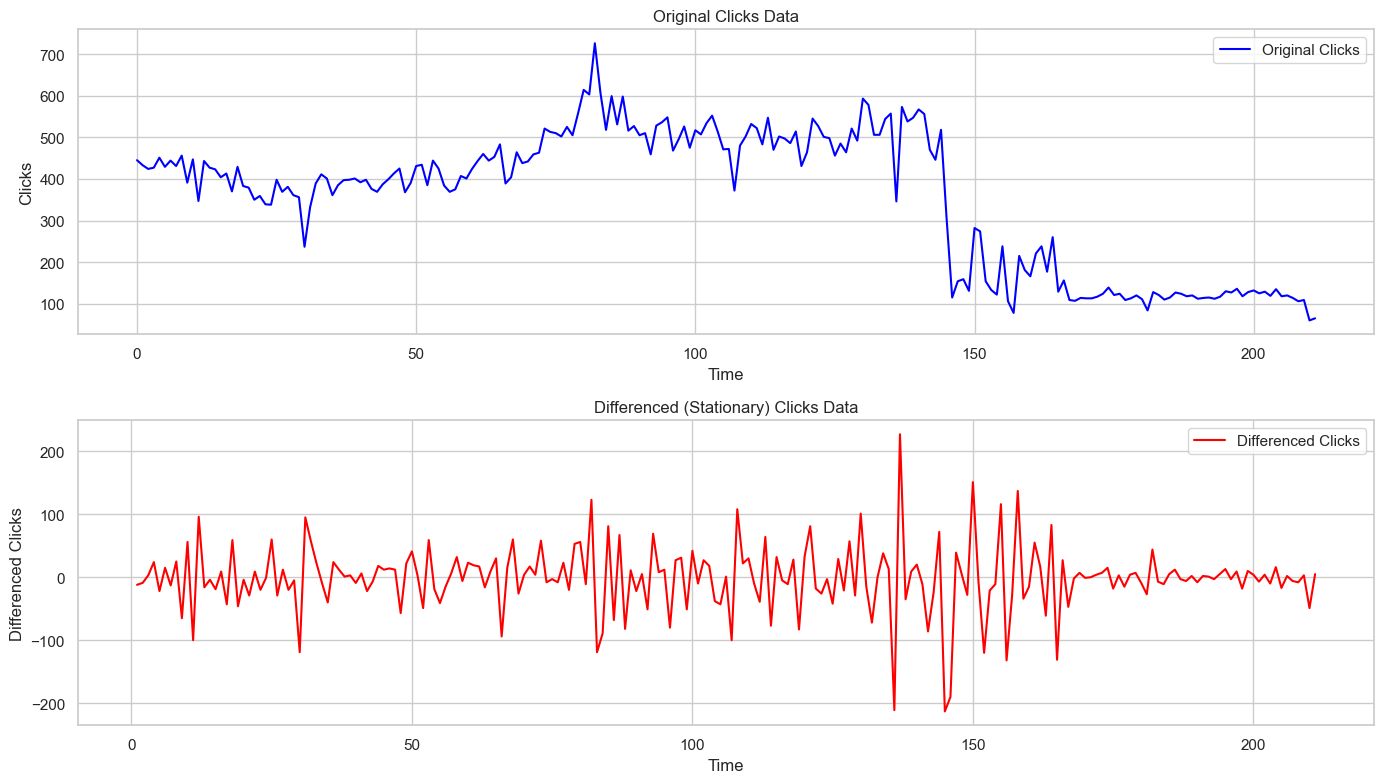

ADF Statistic: -14.224548848059221
p-value: 1.635879634265128e-26
The differenced data is stationary (reject the null hypothesis).


In [40]:
file_path = 'product.xlsx'
data = pd.read_excel(file_path)
data['Clicks_diff'] = data['Clicks'].diff()
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
plt.plot(data['Clicks'], label='Original Clicks', color='blue')
plt.title('Original Clicks Data')
plt.xlabel('Time')
plt.ylabel('Clicks')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data['Clicks_diff'], label='Differenced Clicks', color='red')
plt.title('Differenced (Stationary) Clicks Data')
plt.xlabel('Time')
plt.ylabel('Differenced Clicks')
plt.legend()
plt.tight_layout()
plt.show()
adf_result = adfuller(data['Clicks_diff'].dropna())
adf_statistic, p_value = adf_result[0], adf_result[1]
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("The differenced data is stationary (reject the null hypothesis).")
else:
    print("The differenced data is not stationary (fail to reject the null hypothesis).")

ACF and PACF Plot

ADF Statistic for modified_Quantity: -7.7867605772715045
p-value for modified_Quantity: 8.140842681700413e-12
Number of lags used for modified_Quantity: 1
modified_Quantity is stationary.



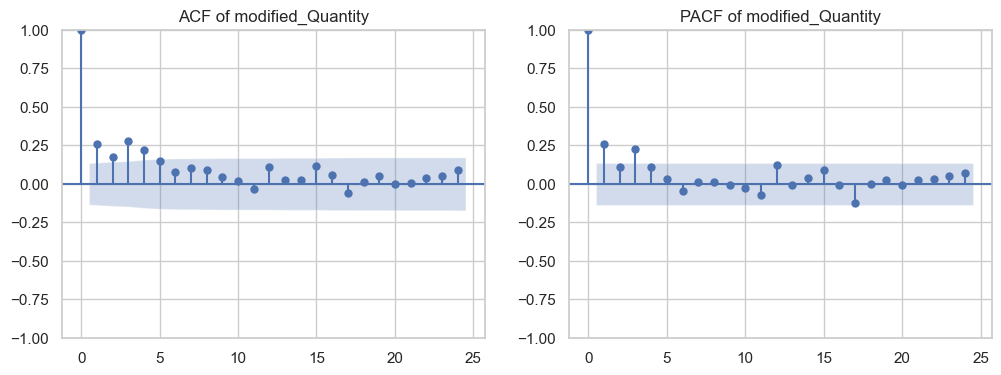

ADF Statistic for Clicks: -0.8705717270828215
p-value for Clicks: 0.797509057499528
Number of lags used for Clicks: 2
Clicks is non-stationary.



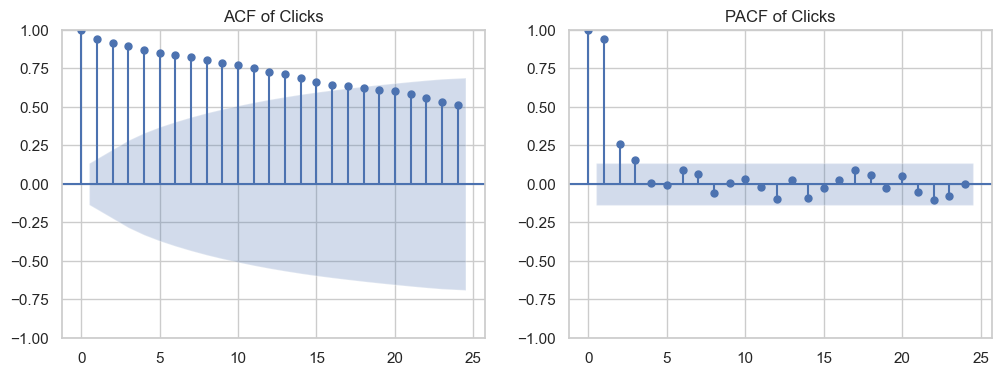

ADF Statistic for Impressions: -5.6962061101258685
p-value for Impressions: 7.863580125889645e-07
Number of lags used for Impressions: 0
Impressions is stationary.



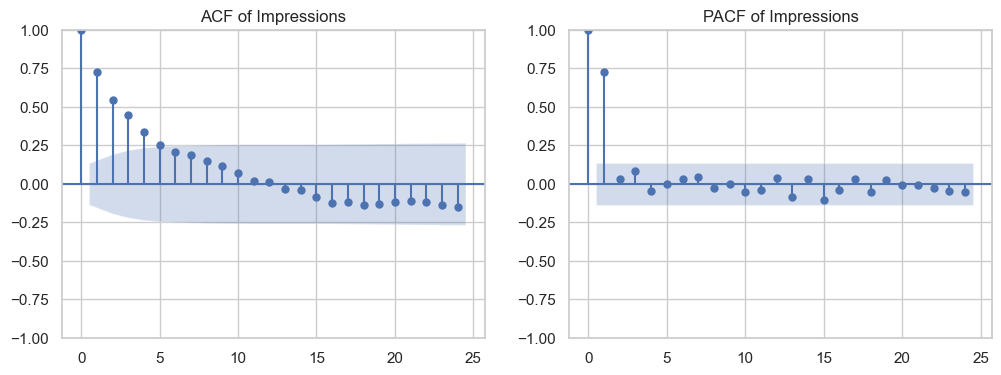

In [41]:
data = pd.read_excel('product.xlsx', sheet_name='Sheet1')
def analyze_series(series, name, lags=None):
    if lags is not None:
        result = adfuller(series, maxlag=lags)
    else:
        result = adfuller(series)
    print(f'ADF Statistic for {name}: {result[0]}')
    print(f'p-value for {name}: {result[1]}')
    print(f'Number of lags used for {name}: {result[2]}')
    print(f'{name} is {"stationary." if result[1] < 0.05 else "non-stationary."}\n')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(series, ax=axes[0])
    plot_pacf(series, ax=axes[1])
    axes[0].set_title(f'ACF of {name}')
    axes[1].set_title(f'PACF of {name}')
    plt.show()
for column in ['modified_Quantity', 'Clicks', 'Impressions']:
    if column == 'modified_Quantity':
        analyze_series(data[column], column, lags=1)
    else:
        analyze_series(data[column], column)

---------------------------

AR model

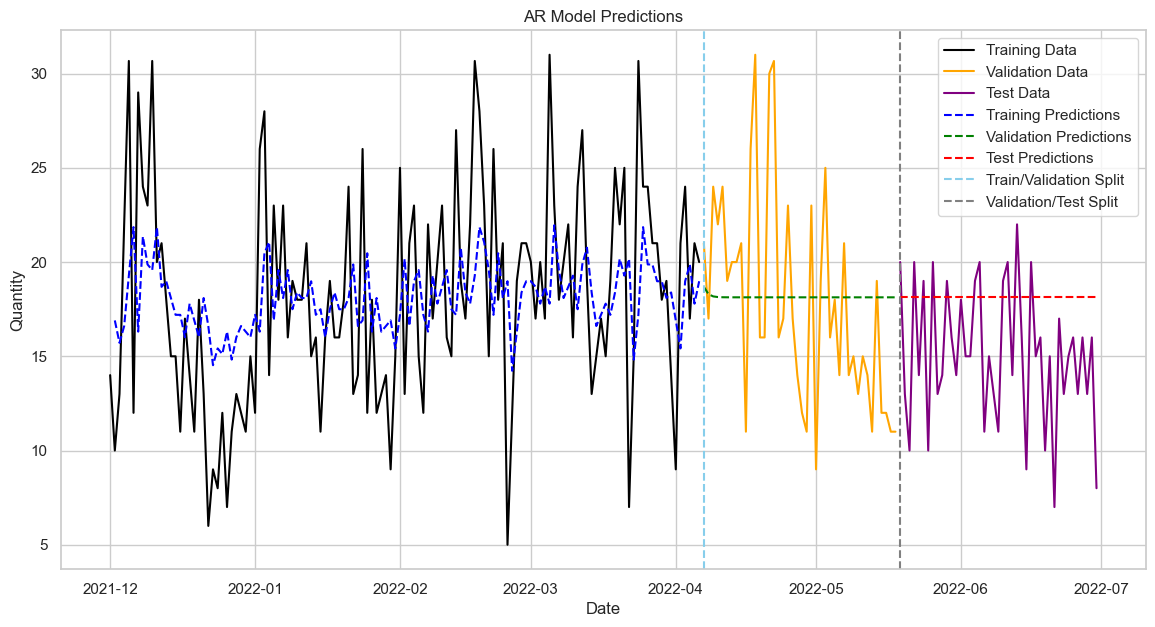

Validation Set Metrics of AR:
MSE: 31.46
RMSE: 5.61
MAE: 4.64
MAPE: 28.85%
R²: 0.00
Adjusted R²: -0.02
Test Set Metrics for AR:
MSE: 22.37
RMSE: 4.73
MAE: 3.90
MAPE: 33.01%
R²: -0.70
Adjusted R²: -0.74


In [42]:
file_path = 'product.xlsx'
data = pd.read_excel(file_path)[['Day Index', 'Year', 'Month', 'Day', 'modified_Quantity', 'Clicks', 'Impressions']]
data = data.sort_values(by='Day Index')
warnings.filterwarnings("ignore")
def split_data(data, train_ratio=0.60, val_ratio=0.20):
    n_total = len(data)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    train_data = data.iloc[:n_train]
    val_data = data.iloc[n_train:n_train + n_val]
    test_data = data.iloc[n_train + n_val:]
    return train_data, val_data, test_data
train_data, val_data, test_data = split_data(data)
train_quantity = train_data['modified_Quantity']
val_quantity = val_data['modified_Quantity']
test_quantity = test_data['modified_Quantity']
ar_model = AutoReg(train_quantity, lags=1).fit()
def predict_ar(model, start, end):
    return model.predict(start=start, end=end)
train_pred = predict_ar(ar_model, start=1, end=len(train_quantity)-1)
val_pred = predict_ar(ar_model, start=len(train_quantity), end=len(train_quantity) + len(val_quantity) - 1)
test_pred = predict_ar(ar_model, start=len(train_quantity) + len(val_quantity), end=len(train_quantity) + len(val_quantity) + len(test_quantity) - 1)
all_data = np.concatenate([train_quantity, val_quantity, test_quantity])
all_pred = np.concatenate([train_pred, val_pred, test_pred])
plt.figure(figsize=(14, 7))
plt.plot(data['Day Index'][:len(train_quantity)], train_quantity, label='Training Data', color='black')
plt.plot(data['Day Index'][len(train_quantity):len(train_quantity) + len(val_quantity)], val_quantity, label='Validation Data', color='orange')
plt.plot(data['Day Index'][len(train_quantity) + len(val_quantity):], test_quantity, label='Test Data', color='purple')
plt.plot(data['Day Index'][1:len(train_pred)+1], train_pred, label='Training Predictions', color='blue', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred)+1:len(train_pred)+len(val_pred)+1], val_pred, label='Validation Predictions', color='green', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred)+len(val_pred)+1:], test_pred, label='Test Predictions', color='red', linestyle='dashed')
plt.axvline(x=data['Day Index'][len(train_quantity)], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'][len(train_quantity) + len(val_quantity)], color='grey', linestyle='--', label='Validation/Test Split')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('AR Model Predictions')
plt.legend()
plt.show()
def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mse)
    ss_res = np.sum((true_values - predicted_values) ** 2)
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    n = len(true_values)
    k = 1
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return mse, rmse, mae, mape, r2, r2_adj
val_true = val_quantity.values
val_pred = val_pred[:len(val_true)]
val_mse, val_rmse, val_mae, val_mape, val_r2, val_r2_adj = evaluate(val_true, val_pred)
test_true = test_quantity.values
test_pred = test_pred[:len(test_true)]
test_mse, test_rmse, test_mae, test_mape, test_r2, test_r2_adj = evaluate(test_true, test_pred)
print(f"Validation Set Metrics of AR:\nMSE: {val_mse:.2f}\nRMSE: {val_rmse:.2f}\nMAE: {val_mae:.2f}\nMAPE: {val_mape:.2f}%\nR²: {val_r2:.2f}\nAdjusted R²: {val_r2_adj:.2f}")
print(f"Test Set Metrics for AR:\nMSE: {test_mse:.2f}\nRMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}\nMAPE: {test_mape:.2f}%\nR²: {test_r2:.2f}\nAdjusted R²: {test_r2_adj:.2f}")

---------------------------

MA model

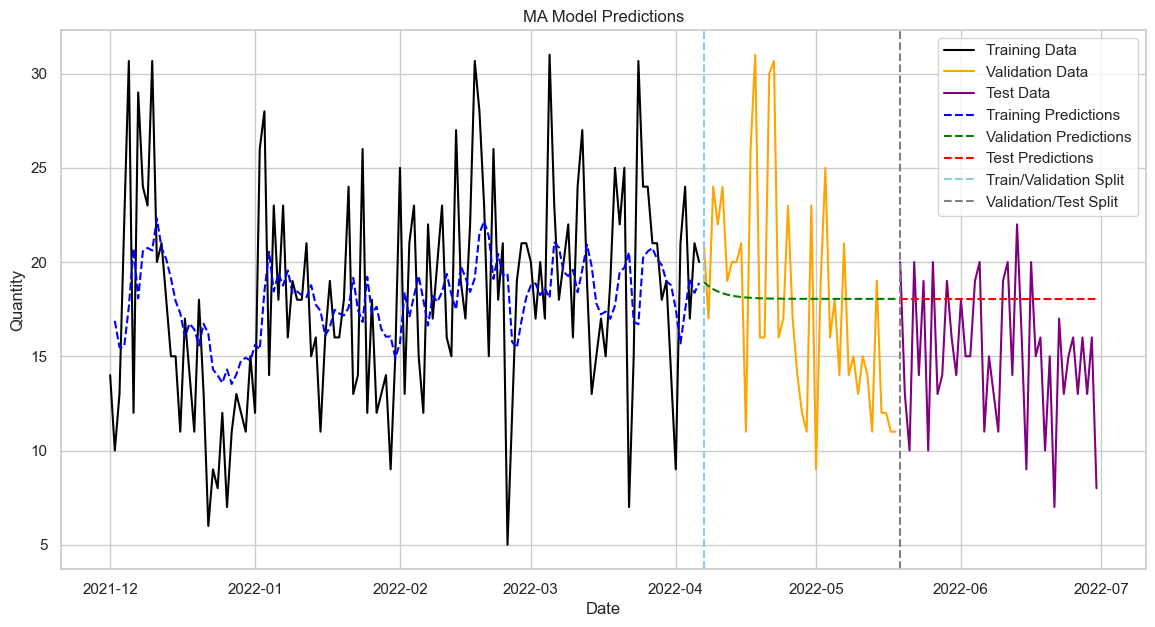

Validation Set Metrics of MA:
MSE: 31.06
RMSE: 5.57
MAE: 4.59
MAPE: 28.51%
R²: 0.01
Adjusted R²: -0.01
Test Set Metrics for MA:
MSE: 21.87
RMSE: 4.68
MAE: 3.86
MAPE: 32.64%
R²: -0.66
Adjusted R²: -0.70


In [43]:
file_path = 'product.xlsx'
data = pd.read_excel(file_path)
data = data[['Day Index', 'Year', 'Month', 'Day', 'modified_Quantity', 'Clicks', 'Impressions']]
data = data.sort_values(by='Day Index')
n_total = len(data)
n_train = int(n_total * 0.60)
n_val = int(n_total * 0.20)
n_test = n_total - n_train - n_val
train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train + n_val]
test_data = data.iloc[n_train + n_val:]
train_quantity = train_data['modified_Quantity']
val_quantity = val_data['modified_Quantity']
test_quantity = test_data['modified_Quantity']
ma_model = ARIMA(train_quantity, order=(1, 0, 1)).fit()
train_pred = ma_model.predict(start=1, end=len(train_quantity)-1)
val_pred = ma_model.predict(start=len(train_quantity), end=len(train_quantity) + len(val_quantity) - 1)
test_pred = ma_model.predict(start=len(train_quantity) + len(val_quantity), end=len(train_quantity) + len(val_quantity) + len(test_quantity) - 1)
all_data = np.concatenate([train_quantity, val_quantity, test_quantity])
all_pred = np.concatenate([train_pred, val_pred, test_pred])
plt.figure(figsize=(14, 7))
plt.plot(data['Day Index'][:n_train], all_data[:n_train], label='Training Data', color='black')
plt.plot(data['Day Index'][n_train:n_train + n_val], all_data[n_train:n_train + n_val], label='Validation Data', color='orange')
plt.plot(data['Day Index'][n_train + n_val:], all_data[n_train + n_val:], label='Test Data', color='purple')
plt.plot(data['Day Index'][1:len(train_pred)+1], train_pred, label='Training Predictions', color='blue', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred)+1:len(train_pred)+len(val_pred)+1], val_pred, label='Validation Predictions', color='green', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred)+len(val_pred)+1:], test_pred, label='Test Predictions', color='red', linestyle='dashed')
plt.axvline(x=data['Day Index'][n_train], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'][n_train + n_val], color='grey', linestyle='--', label='Validation/Test Split')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('MA Model Predictions')
plt.legend()
plt.show()
def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mse)
    ss_res = np.sum((true_values - predicted_values) ** 2)
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    n = len(true_values)
    k = 1 
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return mse, rmse, mae, mape, r2, r2_adj
val_true = val_quantity.values
val_pred = val_pred[:len(val_true)]
val_mse, val_rmse, val_mae, val_mape, val_r2, val_r2_adj = evaluate(val_true, val_pred)
test_true = test_quantity.values
test_pred = test_pred[:len(test_true)]
test_mse, test_rmse, test_mae, test_mape, test_r2, test_r2_adj = evaluate(test_true, test_pred)
print(f"Validation Set Metrics of MA:\nMSE: {val_mse:.2f}\nRMSE: {val_rmse:.2f}\nMAE: {val_mae:.2f}\nMAPE: {val_mape:.2f}%\nR²: {val_r2:.2f}\nAdjusted R²: {val_r2_adj:.2f}")
print(f"Test Set Metrics for MA:\nMSE: {test_mse:.2f}\nRMSE: {test_rmse:.2f}\nMAE: {test_mae:.2f}\nMAPE: {test_mape:.2f}%\nR²: {test_r2:.2f}\nAdjusted R²: {test_r2_adj:.2f}")

---------------------------

ARMA model

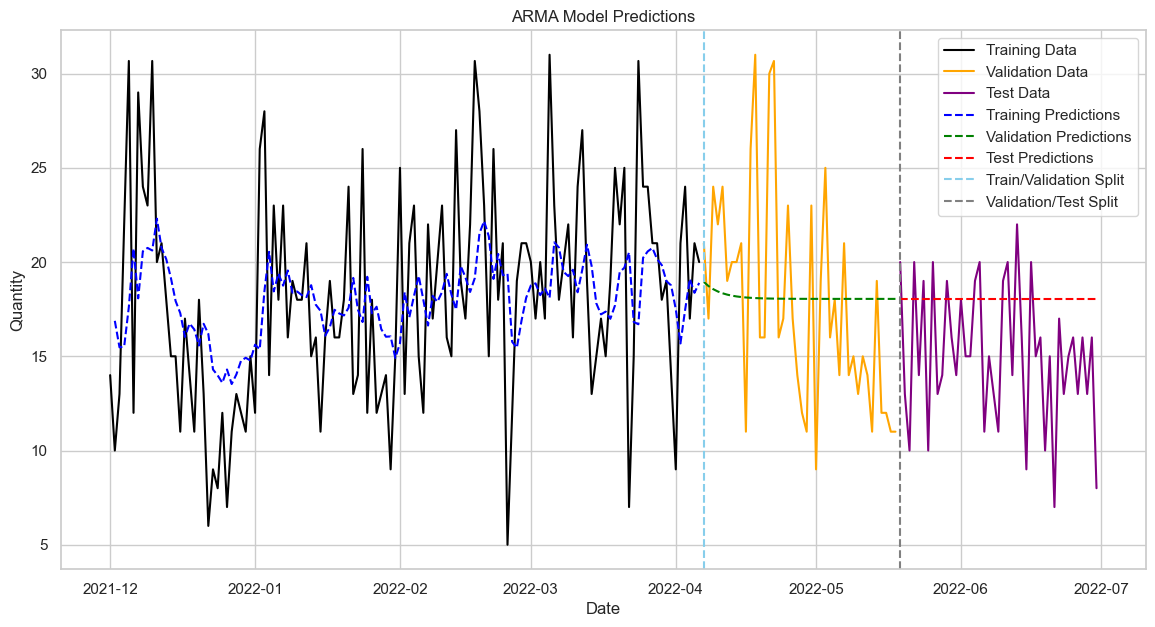

Validation Set Metrics of ARMA:
MSE: 31.06
RMSE: 5.57
MAE: 4.59
MAPE: 28.51%
R²: 0.01
Adjusted R²: -0.01
Test Set Metrics for ARMA:
MSE: 21.87
RMSE: 4.68
MAE: 3.86
MAPE: 32.64%
R²: -0.66
Adjusted R²: -0.70


In [44]:
file_path = 'product.xlsx'
data = pd.read_excel(file_path)
data = data[['Day Index', 'Year', 'Month', 'Day', 'modified_Quantity', 'Clicks', 'Impressions']]
data = data.sort_values(by='Day Index')
n_total = len(data)
n_train = int(n_total * 0.60)
n_val = int(n_total * 0.20)
n_test = n_total - n_train - n_val
train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train + n_val]
test_data = data.iloc[n_train + n_val:]
train_quantity = train_data['modified_Quantity']
val_quantity = val_data['modified_Quantity']
test_quantity = test_data['modified_Quantity']
arma_model = ARIMA(train_quantity, order=(1, 0, 1)).fit()
train_pred_arma = arma_model.predict(start=1, end=len(train_quantity) - 1)
val_pred_arma = arma_model.predict(start=len(train_quantity), end=len(train_quantity) + len(val_quantity) - 1)
test_pred_arma = arma_model.predict(start=len(train_quantity) + len(val_quantity), end=len(train_quantity) + len(val_quantity) + len(test_quantity) - 1)
all_pred_arma = np.concatenate([train_pred_arma, val_pred_arma, test_pred_arma])
plt.figure(figsize=(14, 7))
plt.plot(data['Day Index'][:n_train], train_quantity, label='Training Data', color='black')
plt.plot(data['Day Index'][n_train:n_train + n_val], val_quantity, label='Validation Data', color='orange')
plt.plot(data['Day Index'][n_train + n_val:], test_quantity, label='Test Data', color='purple')
plt.plot(data['Day Index'][1:len(train_pred_arma) + 1], train_pred_arma, label='Training Predictions', color='blue', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred_arma) + 1:len(train_pred_arma) + len(val_pred_arma) + 1], val_pred_arma, label='Validation Predictions', color='green', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred_arma) + len(val_pred_arma) + 1:], test_pred_arma, label='Test Predictions', color='red', linestyle='dashed')
plt.axvline(x=data['Day Index'][n_train], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'][n_train + n_val], color='grey', linestyle='--', label='Validation/Test Split')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('ARMA Model Predictions')
plt.legend()
plt.show()
def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mse)
    ss_res = np.sum((true_values - predicted_values) ** 2)
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    n = len(true_values)
    k = 1 
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return mse, rmse, mae, mape, r2, r2_adj
val_true = val_quantity.values
val_pred_arma = val_pred_arma[:len(val_true)]
val_mse_arma, val_rmse_arma, val_mae_arma, val_mape_arma, val_r2_arma, val_r2_adj_arma = evaluate(val_true, val_pred_arma)
test_true = test_quantity.values
test_pred_arma = test_pred_arma[:len(test_true)]
test_mse_arma, test_rmse_arma, test_mae_arma, test_mape_arma, test_r2_arma, test_r2_adj_arma = evaluate(test_true, test_pred_arma)
print(f"Validation Set Metrics of ARMA:\nMSE: {val_mse_arma:.2f}\nRMSE: {val_rmse_arma:.2f}\nMAE: {val_mae_arma:.2f}\nMAPE: {val_mape_arma:.2f}%\nR²: {val_r2_arma:.2f}\nAdjusted R²: {val_r2_adj_arma:.2f}")
print(f"Test Set Metrics for ARMA:\nMSE: {test_mse_arma:.2f}\nRMSE: {test_rmse_arma:.2f}\nMAE: {test_mae_arma:.2f}\nMAPE: {test_mape_arma:.2f}%\nR²: {test_r2_arma:.2f}\nAdjusted R²: {test_r2_adj_arma:.2f}")

ARIMA model

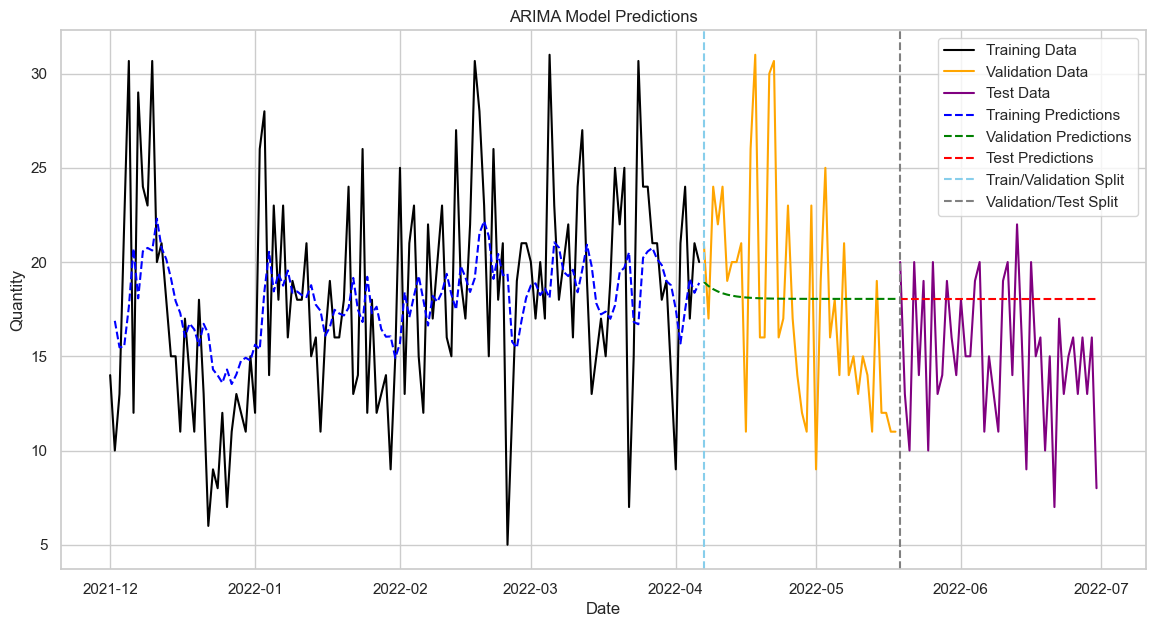

Validation Set Metrics of ARIMA:
MSE: 31.06
RMSE: 5.57
MAE: 4.59
MAPE: 28.51%
R²: 0.01
Adjusted R²: -0.01
Test Set Metrics for ARIMA:
MSE: 21.87
RMSE: 4.68
MAE: 3.86
MAPE: 32.64%
R²: -0.66
Adjusted R²: -0.70


In [45]:
file_path = 'product.xlsx'
data = pd.read_excel(file_path)
data = data[['Day Index', 'Year', 'Month', 'Day', 'modified_Quantity', 'Clicks', 'Impressions']]
data = data.sort_values(by='Day Index')
n_total = len(data)
n_train = int(n_total * 0.60)
n_val = int(n_total * 0.20)
n_test = n_total - n_train - n_val
train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train + n_val]
test_data = data.iloc[n_train + n_val:]
train_quantity = train_data['modified_Quantity']
val_quantity = val_data['modified_Quantity']
test_quantity = test_data['modified_Quantity']
arima_model = ARIMA(train_quantity, order=(1, 0, 1)).fit()
train_pred_arima = arima_model.predict(start=1, end=len(train_quantity) - 1, typ='levels')
val_pred_arima = arima_model.predict(start=len(train_quantity), end=len(train_quantity) + len(val_quantity) - 1, typ='levels')
test_pred_arima = arima_model.predict(start=len(train_quantity) + len(val_quantity), end=len(train_quantity) + len(val_quantity) + len(test_quantity) - 1, typ='levels')
all_pred_arima = np.concatenate([train_pred_arima, val_pred_arima, test_pred_arima])
plt.figure(figsize=(14, 7))
plt.plot(data['Day Index'][:n_train], train_quantity, label='Training Data', color='black')
plt.plot(data['Day Index'][n_train:n_train + n_val], val_quantity, label='Validation Data', color='orange')
plt.plot(data['Day Index'][n_train + n_val:], test_quantity, label='Test Data', color='purple')
plt.plot(data['Day Index'][1:len(train_pred_arima) + 1], train_pred_arima, label='Training Predictions', color='blue', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred_arima) + 1:len(train_pred_arima) + len(val_pred_arima) + 1], val_pred_arima, label='Validation Predictions', color='green', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred_arima) + len(val_pred_arima) + 1:], test_pred_arima, label='Test Predictions', color='red', linestyle='dashed')
plt.axvline(x=data['Day Index'][n_train], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'][n_train + n_val], color='grey', linestyle='--', label='Validation/Test Split')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('ARIMA Model Predictions')
plt.legend()
plt.show()
def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mse)
    ss_res = np.sum((true_values - predicted_values) ** 2)
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    n = len(true_values)
    k = 1  
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return mse, rmse, mae, mape, r2, r2_adj
val_true = val_quantity.values
val_pred_arima = val_pred_arima[:len(val_true)]
val_mse_arima, val_rmse_arima, val_mae_arima, val_mape_arima, val_r2_arima, val_r2_adj_arima = evaluate(val_true, val_pred_arima)
test_true = test_quantity.values
test_pred_arima = test_pred_arima[:len(test_true)]
test_mse_arima, test_rmse_arima, test_mae_arima, test_mape_arima, test_r2_arima, test_r2_adj_arima = evaluate(test_true, test_pred_arima)
print(f"Validation Set Metrics of ARIMA:\nMSE: {val_mse_arima:.2f}\nRMSE: {val_rmse_arima:.2f}\nMAE: {val_mae_arima:.2f}\nMAPE: {val_mape_arima:.2f}%\nR²: {val_r2_arima:.2f}\nAdjusted R²: {val_r2_adj_arima:.2f}")
print(f"Test Set Metrics for ARIMA:\nMSE: {test_mse_arima:.2f}\nRMSE: {test_rmse_arima:.2f}\nMAE: {test_mae_arima:.2f}\nMAPE: {test_mape_arima:.2f}%\nR²: {test_r2_arima:.2f}\nAdjusted R²: {test_r2_adj_arima:.2f}")

SARIMA model

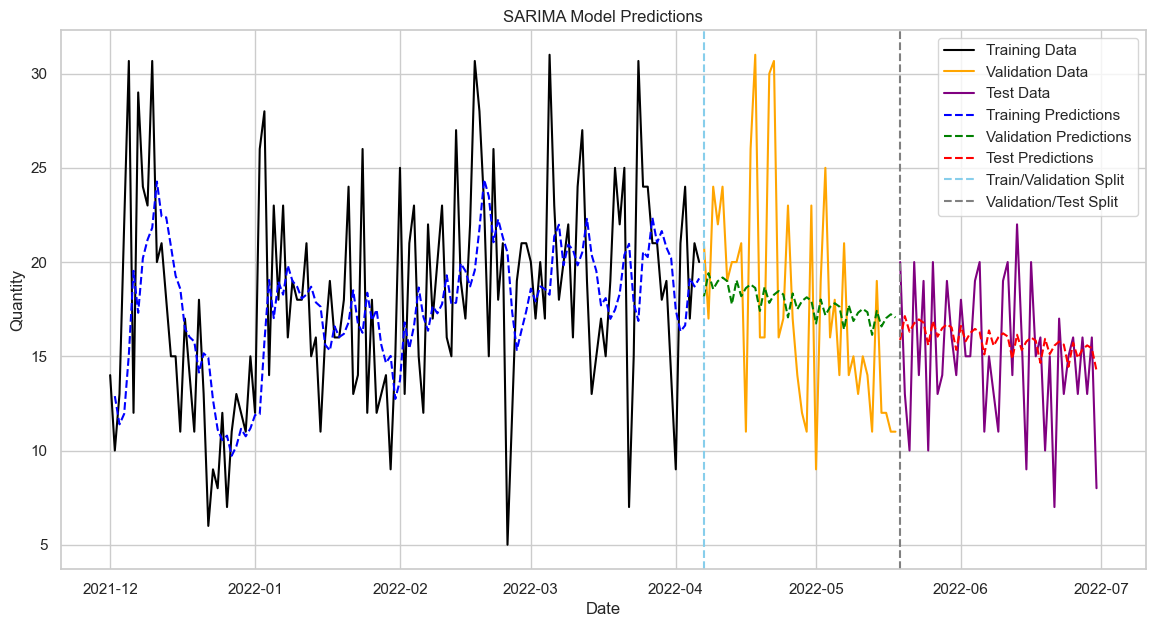

Validation Set Metrics of SARIMA:
MSE: 28.45
RMSE: 5.33
MAE: 4.38
MAPE: 26.56%
R²: 0.10
Adjusted R²: 0.07
Test Set Metrics for SARIMA:
MSE: 12.27
RMSE: 3.50
MAE: 2.85
MAPE: 22.87%
R²: 0.07
Adjusted R²: 0.04


In [46]:
file_path = 'product.xlsx'
data = pd.read_excel(file_path)
data = data[['Day Index', 'Year', 'Month', 'Day', 'modified_Quantity', 'Clicks', 'Impressions']]
data = data.sort_values(by='Day Index')
n_total = len(data)
n_train = int(n_total * 0.60)
n_val = int(n_total * 0.20)
n_test = n_total - n_train - n_val
train_data = data.iloc[:n_train]
val_data = data.iloc[n_train:n_train + n_val]
test_data = data.iloc[n_train + n_val:]
train_quantity = train_data['modified_Quantity']
val_quantity = val_data['modified_Quantity']
test_quantity = test_data['modified_Quantity']
sarima_model = SARIMAX(train_quantity, order=(1, 0, 1), seasonal_order=(1, 0, 1, 6))
sarima_fit = sarima_model.fit()
train_pred_sarima = sarima_fit.predict(start=1, end=len(train_quantity) - 1)
val_pred_sarima = sarima_fit.predict(start=len(train_quantity), end=len(train_quantity) + len(val_quantity) - 1)
test_pred_sarima = sarima_fit.predict(start=len(train_quantity) + len(val_quantity), end=len(train_quantity) + len(val_quantity) + len(test_quantity) - 1)
all_pred_sarima = np.concatenate([train_pred_sarima, val_pred_sarima, test_pred_sarima])
plt.figure(figsize=(14, 7))
plt.plot(data['Day Index'][:n_train], train_quantity, label='Training Data', color='black')
plt.plot(data['Day Index'][n_train:n_train + n_val], val_quantity, label='Validation Data', color='orange')
plt.plot(data['Day Index'][n_train + n_val:], test_quantity, label='Test Data', color='purple')
plt.plot(data['Day Index'][1:len(train_pred_sarima) + 1], train_pred_sarima, label='Training Predictions', color='blue', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred_sarima) + 1:len(train_pred_sarima) + len(val_pred_sarima) + 1], val_pred_sarima, label='Validation Predictions', color='green', linestyle='dashed')
plt.plot(data['Day Index'][len(train_pred_sarima) + len(val_pred_sarima) + 1:], test_pred_sarima, label='Test Predictions', color='red', linestyle='dashed')
plt.axvline(x=data['Day Index'][n_train], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'][n_train + n_val], color='grey', linestyle='--', label='Validation/Test Split')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('SARIMA Model Predictions')
plt.legend()
plt.show()
def evaluate(true_values, predicted_values):
    mse = mean_squared_error(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    rmse = np.sqrt(mse)
    ss_res = np.sum((true_values - predicted_values) ** 2)
    ss_tot = np.sum((true_values - np.mean(true_values)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    n = len(true_values)
    k = 1 
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    return mse, rmse, mae, mape, r2, r2_adj
val_true = val_quantity.values
val_pred_sarima = val_pred_sarima[:len(val_true)]
val_mse_sarima, val_rmse_sarima, val_mae_sarima, val_mape_sarima, val_r2_sarima, val_r2_adj_sarima = evaluate(val_true, val_pred_sarima)
test_true = test_quantity.values
test_pred_sarima = test_pred_sarima[:len(test_true)]
test_mse_sarima, test_rmse_sarima, test_mae_sarima, test_mape_sarima, test_r2_sarima, test_r2_adj_sarima = evaluate(test_true, test_pred_sarima)
print(f"Validation Set Metrics of SARIMA:\nMSE: {val_mse_sarima:.2f}\nRMSE: {val_rmse_sarima:.2f}\nMAE: {val_mae_sarima:.2f}\nMAPE: {val_mape_sarima:.2f}%\nR²: {val_r2_sarima:.2f}\nAdjusted R²: {val_r2_adj_sarima:.2f}")
print(f"Test Set Metrics for SARIMA:\nMSE: {test_mse_sarima:.2f}\nRMSE: {test_rmse_sarima:.2f}\nMAE: {test_mae_sarima:.2f}\nMAPE: {test_mape_sarima:.2f}%\nR²: {test_r2_sarima:.2f}\nAdjusted R²: {test_r2_adj_sarima:.2f}")

ARIMAX model

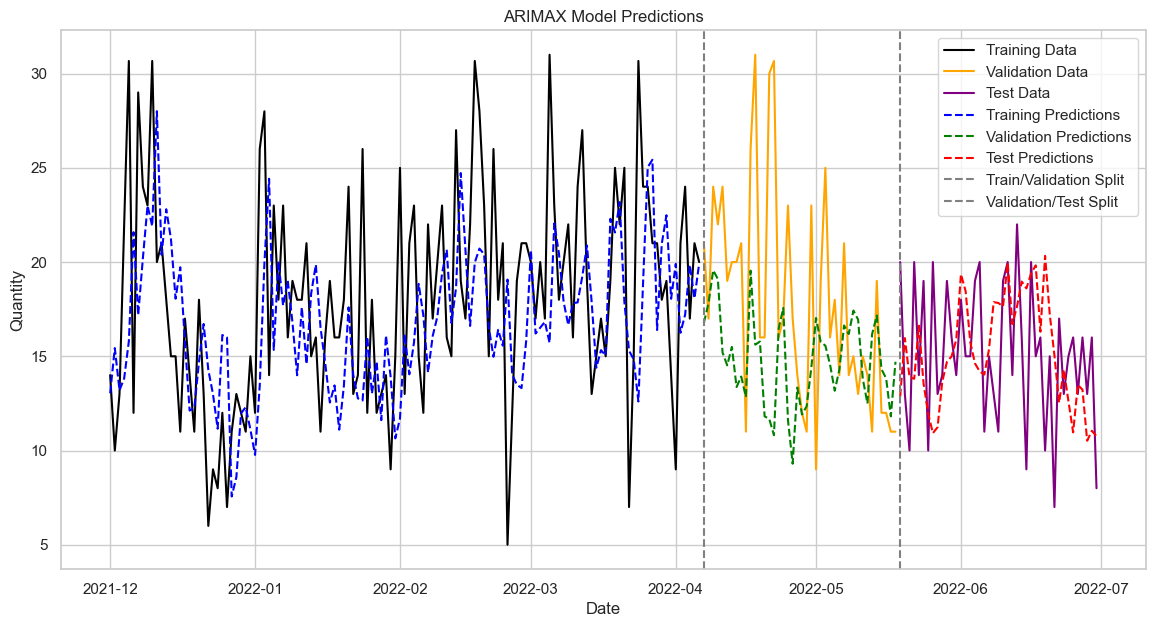

ARIMAX Validation Set Metrics:
MSE: 43.93689458366877
RMSE: 6.628491124205325
MAE: 4.750427560280521
MAPE: 24.354%
R²: -0.40
Adjusted R²: -0.55

ARIMAX Test Set Metrics:
MSE: 19.466163811613054
RMSE: 4.412047575855575
MAE: 3.5674229306320338
MAPE: 26.678%
R²: -0.48
Adjusted R²: -0.64


In [47]:
warnings.filterwarnings("ignore")
file_path = 'product.xlsx'
df = pd.read_excel(file_path)
df['Day Index'] = pd.to_datetime(df['Day Index'])
df.set_index('Day Index', inplace=True)
df['DayOfWeek_numeric'] = df.index.dayofweek
df['Month_numeric'] = df.index.month
df['Clicks_stationary'] = df['Clicks'].diff().fillna(0)
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]
train_df = train_df.dropna(subset=['Clicks_stationary'])
val_df = val_df.dropna(subset=['Clicks_stationary'])
test_df = test_df.dropna(subset=['Clicks_stationary'])
exog_train = train_df[['Clicks_stationary', 'Impressions', 'DayOfWeek_numeric', 'Month_numeric']]
exog_val = val_df[['Clicks_stationary', 'Impressions', 'DayOfWeek_numeric', 'Month_numeric']]
exog_test = test_df[['Clicks_stationary', 'Impressions', 'DayOfWeek_numeric', 'Month_numeric']]
def plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, model, model_name):
    predictions_val = model.get_forecast(steps=len(val_df), exog=exog_val).predicted_mean
    predictions_test = model.get_forecast(steps=len(test_df), exog=exog_test).predicted_mean
    plt.figure(figsize=(14, 7))
    plt.plot(train_df.index, train_df['modified_Quantity'], label='Training Data', color='black')
    plt.plot(val_df.index, val_df['modified_Quantity'], label='Validation Data', color='orange')
    plt.plot(test_df.index, test_df['modified_Quantity'], label='Test Data', color='purple')
    plt.plot(train_df.index, model.fittedvalues, label='Training Predictions', color='blue', linestyle='dashed')
    plt.plot(val_df.index, predictions_val, label='Validation Predictions', color='green', linestyle='dashed')
    plt.plot(test_df.index, predictions_test, label='Test Predictions', color='red', linestyle='dashed')
    plt.axvline(x=val_df.index[0], color='grey', linestyle='--', label='Train/Validation Split')
    plt.axvline(x=test_df.index[0], color='grey', linestyle='--', label='Validation/Test Split')
    plt.legend()
    plt.title(f'{model_name} Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.show()
    def calculate_mape(actual_values, predicted_values):
        actual_values = np.array(actual_values)
        predicted_values = np.array(predicted_values)
        abs_percentage_error = np.abs((actual_values - predicted_values) / actual_values)
        abs_percentage_error[np.isnan(abs_percentage_error)] = 0
        mape = np.mean(abs_percentage_error) * 100
        return mape
    mse_val = mean_squared_error(val_df['modified_Quantity'], predictions_val)
    mae_val = mean_absolute_error(val_df['modified_Quantity'], predictions_val)
    mape_val = calculate_mape(val_df['modified_Quantity'], predictions_val)
    rmse_val = np.sqrt(mse_val)
    mse_test = mean_squared_error(test_df['modified_Quantity'], predictions_test)
    mae_test = mean_absolute_error(test_df['modified_Quantity'], predictions_test)
    mape_test = calculate_mape(test_df['modified_Quantity'], predictions_test)
    rmse_test = np.sqrt(mse_test)
    r2_val = r2_score(val_df['modified_Quantity'], predictions_val)
    n_val = len(val_df)
    p_val = exog_val.shape[1]
    r2_adj_val = 1 - (1 - r2_val) * (n_val - 1) / (n_val - p_val - 1)
    r2_test = r2_score(test_df['modified_Quantity'], predictions_test)
    n_test = len(test_df)
    p_test = exog_test.shape[1]
    r2_adj_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)
    print(f'{model_name} Validation Set Metrics:\nMSE: {mse_val}\nRMSE: {rmse_val}\nMAE: {mae_val}\nMAPE: {mape_val.round(3)}%\nR²: {r2_val:.2f}\nAdjusted R²: {r2_adj_val:.2f}')
    print(f'\n{model_name} Test Set Metrics:\nMSE: {mse_test}\nRMSE: {rmse_test}\nMAE: {mae_test}\nMAPE: {mape_test.round(3)}%\nR²: {r2_test:.2f}\nAdjusted R²: {r2_adj_test:.2f}')
arimax_model = SARIMAX(train_df['modified_Quantity'], exog=exog_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 6)).fit()
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, arimax_model, 'ARIMAX')

------------------------------------

SARIMAX model

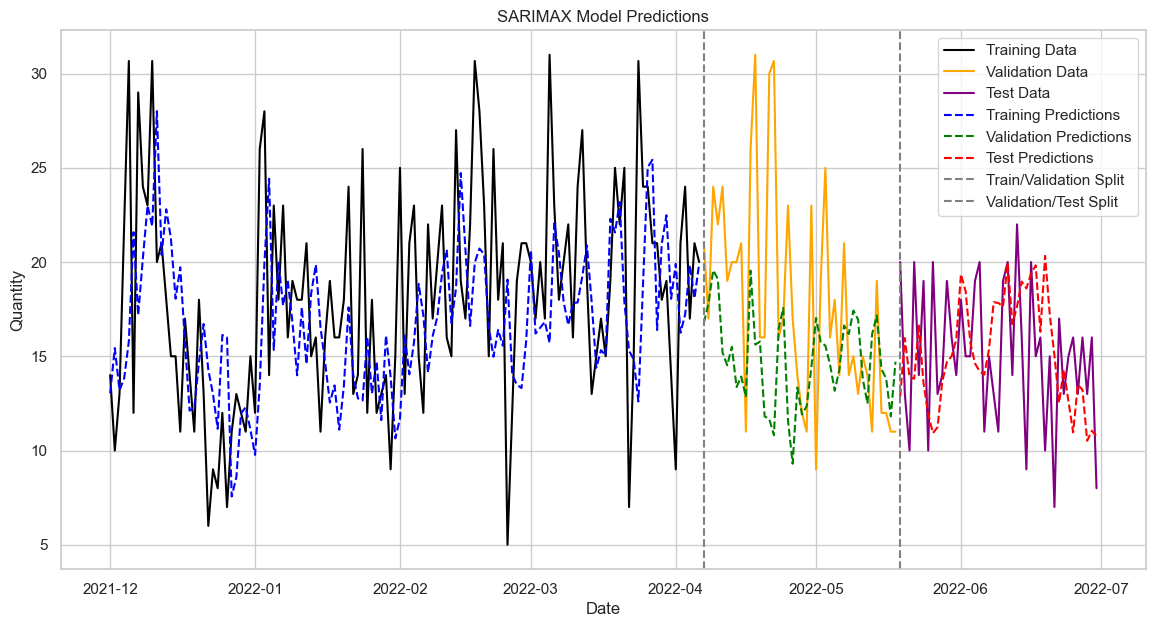

SARIMAX Validation Set Metrics:
MSE: 43.93689458366877
RMSE: 6.628491124205325
MAE: 4.750427560280521
MAPE: 24.354%
R²: -0.40
Adjusted R²: -0.55

SARIMAX Test Set Metrics:
MSE: 19.466163811613054
RMSE: 4.412047575855575
MAE: 3.5674229306320338
MAPE: 26.678%
R²: -0.48
Adjusted R²: -0.64


In [48]:
file_path = 'product.xlsx'
df = pd.read_excel(file_path)
df['Day Index'] = pd.to_datetime(df['Day Index'])
df.set_index('Day Index', inplace=True)
df['DayOfWeek_numeric'] = df.index.dayofweek
df['Month_numeric'] = df.index.month
df['Clicks_stationary'] = df['Clicks'].diff().fillna(0)
train_size = int(len(df) * 0.6)
val_size = int(len(df) * 0.2)
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]
train_df = train_df.dropna(subset=['Clicks_stationary'])
val_df = val_df.dropna(subset=['Clicks_stationary'])
test_df = test_df.dropna(subset=['Clicks_stationary'])
exog_train = train_df[['Clicks_stationary', 'Impressions', 'DayOfWeek_numeric', 'Month_numeric']]
exog_val = val_df[['Clicks_stationary', 'Impressions', 'DayOfWeek_numeric', 'Month_numeric']]
exog_test = test_df[['Clicks_stationary', 'Impressions', 'DayOfWeek_numeric', 'Month_numeric']]
def plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, model, model_name):
    predictions_val = model.get_forecast(steps=len(val_df), exog=exog_val).predicted_mean
    predictions_test = model.get_forecast(steps=len(test_df), exog=exog_test).predicted_mean
    plt.figure(figsize=(14, 7))
    plt.plot(train_df.index, train_df['modified_Quantity'], label='Training Data', color='black')
    plt.plot(val_df.index, val_df['modified_Quantity'], label='Validation Data', color='orange')
    plt.plot(test_df.index, test_df['modified_Quantity'], label='Test Data', color='purple')
    plt.plot(train_df.index, model.fittedvalues, label='Training Predictions', color='blue', linestyle='dashed')
    plt.plot(val_df.index, predictions_val, label='Validation Predictions', color='green', linestyle='dashed')
    plt.plot(test_df.index, predictions_test, label='Test Predictions', color='red', linestyle='dashed')
    plt.axvline(x=val_df.index[0], color='grey', linestyle='--', label='Train/Validation Split')
    plt.axvline(x=test_df.index[0], color='grey', linestyle='--', label='Validation/Test Split')
    plt.legend()
    plt.title(f'{model_name} Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.show()
    def calculate_mape(actual_values, predicted_values):
        actual_values = np.array(actual_values)
        predicted_values = np.array(predicted_values)
        abs_percentage_error = np.abs((actual_values - predicted_values) / actual_values)
        abs_percentage_error[np.isnan(abs_percentage_error)] = 0
        mape = np.mean(abs_percentage_error) * 100
        return mape
    mse_val = mean_squared_error(val_df['modified_Quantity'], predictions_val)
    mae_val = mean_absolute_error(val_df['modified_Quantity'], predictions_val)
    mape_val = calculate_mape(val_df['modified_Quantity'], predictions_val)
    rmse_val = np.sqrt(mse_val)
    mse_test = mean_squared_error(test_df['modified_Quantity'], predictions_test)
    mae_test = mean_absolute_error(test_df['modified_Quantity'], predictions_test)
    mape_test = calculate_mape(test_df['modified_Quantity'], predictions_test)
    rmse_test = np.sqrt(mse_test)
    r2_val = r2_score(val_df['modified_Quantity'], predictions_val)
    n_val = len(val_df)
    p_val = exog_val.shape[1]
    r2_adj_val = 1 - (1 - r2_val) * (n_val - 1) / (n_val - p_val - 1)
    r2_test = r2_score(test_df['modified_Quantity'], predictions_test)
    n_test = len(test_df)
    p_test = exog_test.shape[1]
    r2_adj_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)
    print(f'{model_name} Validation Set Metrics:\nMSE: {mse_val}\nRMSE: {rmse_val}\nMAE: {mae_val}\nMAPE: {mape_val.round(3)}%\nR²: {r2_val:.2f}\nAdjusted R²: {r2_adj_val:.2f}')
    print(f'\n{model_name} Test Set Metrics:\nMSE: {mse_test}\nRMSE: {rmse_test}\nMAE: {mae_test}\nMAPE: {mape_test.round(3)}%\nR²: {r2_test:.2f}\nAdjusted R²: {r2_adj_test:.2f}')
sarimax_model = SARIMAX(train_df['modified_Quantity'], exog=exog_train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 6)).fit()
plot_predictions_and_metrics_exog(train_df, val_df, test_df, exog_val, exog_test, sarimax_model, 'SARIMAX')

---------------------------------------------

Multivariate regression

Multivariate regression Validation Set Metrics:
MSE: 29.19
RMSE: 5.40
MAE: 4.25
MAPE: 30.09%
R²: -0.09
Adjusted R²: -0.20

Multivariate regression Test Set Metrics:
MSE: 18.69
RMSE: 4.32
MAE: 3.48
MAPE: 22.61%
R²: 0.29
Adjusted R²: 0.22


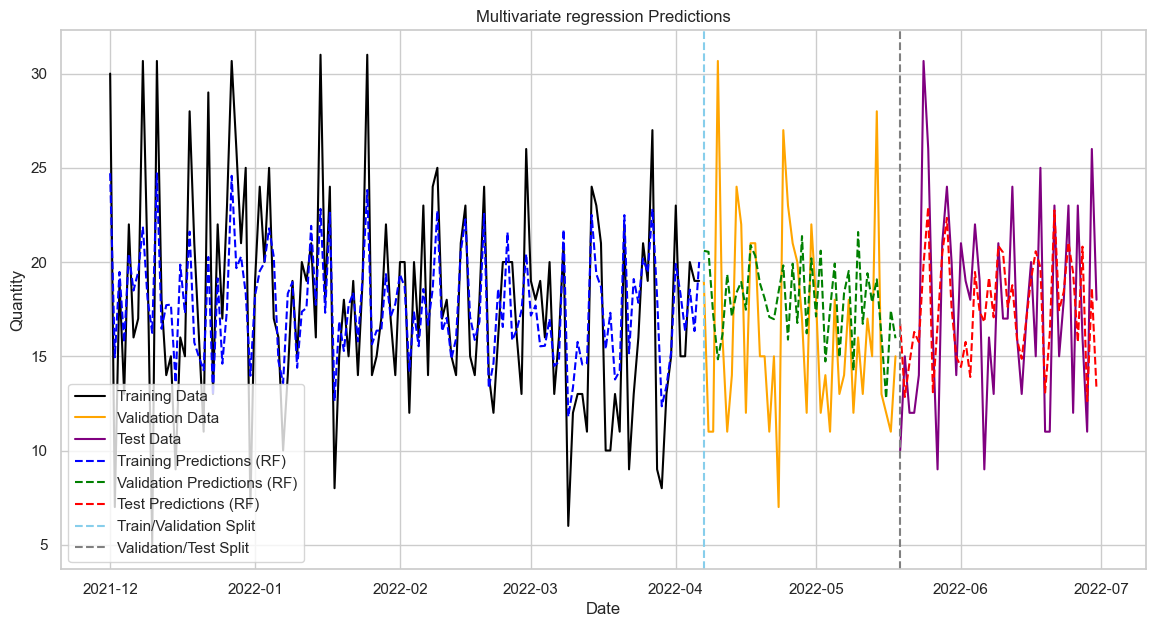

In [49]:

file_path = 'product.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')
data['DayOfWeek_numeric'] = pd.Categorical(data['Day']).codes
data['Month_numeric'] = pd.Categorical(data['Month']).codes
X = data[['Clicks', 'Impressions', 'DayOfWeek_numeric', 'Month_numeric']]
y = data['modified_Quantity']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - X_val.shape[1] - 1)
    return mse, rmse, mae, mape, r2, adj_r2
rf = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_absolute_percentage_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_
rf_train_pred = rf_best.predict(X_train)
rf_val_pred = rf_best.predict(X_val)
rf_test_pred = rf_best.predict(X_test)
rf_val_mse, rf_val_rmse, rf_val_mae, rf_val_mape, rf_val_r2, rf_val_adj_r2 = calculate_metrics(y_val, rf_val_pred)
rf_test_mse, rf_test_rmse, rf_test_mae, rf_test_mape, rf_test_r2, rf_test_adj_r2 = calculate_metrics(y_test, rf_test_pred)
print(f'Multivariate regression Validation Set Metrics:')
print(f'MSE: {rf_val_mse:.2f}')
print(f'RMSE: {rf_val_rmse:.2f}')
print(f'MAE: {rf_val_mae:.2f}')
print(f'MAPE: {rf_val_mape:.2f}%')
print(f'R²: {rf_val_r2:.2f}')
print(f'Adjusted R²: {rf_val_adj_r2:.2f}')
print()
print(f'Multivariate regression Test Set Metrics:')
print(f'MSE: {rf_test_mse:.2f}')
print(f'RMSE: {rf_test_rmse:.2f}')
print(f'MAE: {rf_test_mae:.2f}')
print(f'MAPE: {rf_test_mape:.2f}%')
print(f'R²: {rf_test_r2:.2f}')
print(f'Adjusted R²: {rf_test_adj_r2:.2f}')
plt.figure(figsize=(14, 7))
plt.plot(data['Day Index'][:len(y_train)], y_train, label='Training Data', color='black')
plt.plot(data['Day Index'][len(y_train):len(y_train) + len(y_val)], y_val, label='Validation Data', color='orange')
plt.plot(data['Day Index'][len(y_train) + len(y_val):], y_test, label='Test Data', color='purple')
plt.plot(data['Day Index'][:len(rf_train_pred)], rf_train_pred, label='Training Predictions (RF)', color='blue', linestyle='dashed')
plt.plot(data['Day Index'][len(rf_train_pred):len(rf_train_pred)+len(rf_val_pred)], rf_val_pred, label='Validation Predictions (RF)', color='green', linestyle='dashed')
plt.plot(data['Day Index'][len(rf_train_pred)+len(rf_val_pred):], rf_test_pred, label='Test Predictions (RF)', color='red', linestyle='dashed')
plt.axvline(x=data['Day Index'].iloc[len(y_train)], color='skyblue', linestyle='--', label='Train/Validation Split')
plt.axvline(x=data['Day Index'].iloc[len(y_train) + len(y_val)], color='grey', linestyle='--', label='Validation/Test Split')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Multivariate regression Predictions')
plt.legend()
plt.show()

---------------------------------------

Creating different table of Validation Set Metrics and Test Set Metrics for different models (AR, MA, ARMA, ARIMA, SARIMA, ARIMAX, SARIMAX)

In [50]:
validation_metrics = {
    'Model': ['AR', 'MA', 'ARMA', 'ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX', 'Multivariate_regression'],
    'MSE': [31.46, 31.06, 31.06, 31.06, 28.45, 47.41, 47.41, 29.19],
    'RMSE': [5.61, 5.57, 5.57, 5.57, 5.33, 6.89, 6.89, 5.40],
    'MAE': [4.64, 4.59, 4.59, 4.59, 4.38, 5.06, 5.06, 4.25],
    'MAPE': [28.85, 28.51, 28.51, 28.51, 26.56, 24.92, 24.92, 30.09],
    'R²': [0.00, 0.01, 0.01, 0.01, 0.10, -0.40, -0.40, -0.09],
    'Adjusted_R²': [-0.02, -0.01, -0.01, -0.01, 0.07, -0.55, -0.55, -0.20]
}
validation_df = pd.DataFrame(validation_metrics)
test_metrics = {
    'Model': ['AR', 'MA', 'ARMA', 'ARIMA', 'SARIMA', 'ARIMAX', 'SARIMAX', 'Multivariate_regression'],
    'MSE': [22.37, 21.87, 21.87, 21.87, 12.27, 15.62, 15.62, 18.69],
    'RMSE': [4.73, 4.68, 4.68, 4.68, 3.50, 3.95, 3.95, 4.32],
    'MAE': [3.90, 3.86, 3.86, 3.86, 2.85, 3.36, 3.36, 3.48],
    'MAPE': [33.01, 32.64, 32.64, 32.64, 22.87, 23.67,23.67, 22.61],
    'R²': [-0.70, -0.66, -0.66, -0.66, 0.07, -0.48, -0.48, 0.29],
    'Adjusted_R²': [-0.74, -0.70, -0.70, -0.70, 0.04, -0.64, -0.64, 0.22]
}
test_df = pd.DataFrame(test_metrics)
min_mse_model = test_df.loc[test_df['MSE'].idxmin()]['Model']
min_rmse_model = test_df.loc[test_df['RMSE'].idxmin()]['Model']
min_mae_model = test_df.loc[test_df['MAE'].idxmin()]['Model']
min_mape_model = test_df.loc[test_df['MAPE'].idxmin()]['Model']
max_R2_model = test_df.loc[test_df['R²'].idxmax()]['Model']
max_Adjusted_R2_model = test_df.loc[test_df['Adjusted_R²'].idxmax()]['Model']
print("Validation Set Metrics:")
print(validation_df)
print("\nTest Set Metrics:")
print(test_df)
print(f"\nBest Model based on Test Set Metrics:\nLowest MSE: {min_mse_model}\nLowest RMSE: {min_rmse_model}\nLowest MAE: {min_mae_model}\nLowest MAPE: {min_mape_model}\nHighest R²: {max_R2_model}\nHighest Adjusted R²: {max_Adjusted_R2_model}")
print(f"\nSo the best prediction model for the given data set is{min_rmse_model}")
excel_file = 'time_series_model_comparison.xlsx'
with pd.ExcelWriter(excel_file) as writer:
    validation_df.to_excel(writer, sheet_name='Validation Set Metrics', index=False)
    test_df.to_excel(writer, sheet_name='Test Set Metrics', index=False)
print(f"\nData saved to {excel_file}.")

Validation Set Metrics:
                     Model    MSE  RMSE   MAE   MAPE    R²  Adjusted_R²
0                       AR  31.46  5.61  4.64  28.85  0.00        -0.02
1                       MA  31.06  5.57  4.59  28.51  0.01        -0.01
2                     ARMA  31.06  5.57  4.59  28.51  0.01        -0.01
3                    ARIMA  31.06  5.57  4.59  28.51  0.01        -0.01
4                   SARIMA  28.45  5.33  4.38  26.56  0.10         0.07
5                   ARIMAX  47.41  6.89  5.06  24.92 -0.40        -0.55
6                  SARIMAX  47.41  6.89  5.06  24.92 -0.40        -0.55
7  Multivariate_regression  29.19  5.40  4.25  30.09 -0.09        -0.20

Test Set Metrics:
                     Model    MSE  RMSE   MAE   MAPE    R²  Adjusted_R²
0                       AR  22.37  4.73  3.90  33.01 -0.70        -0.74
1                       MA  21.87  4.68  3.86  32.64 -0.66        -0.70
2                     ARMA  21.87  4.68  3.86  32.64 -0.66        -0.70
3                    

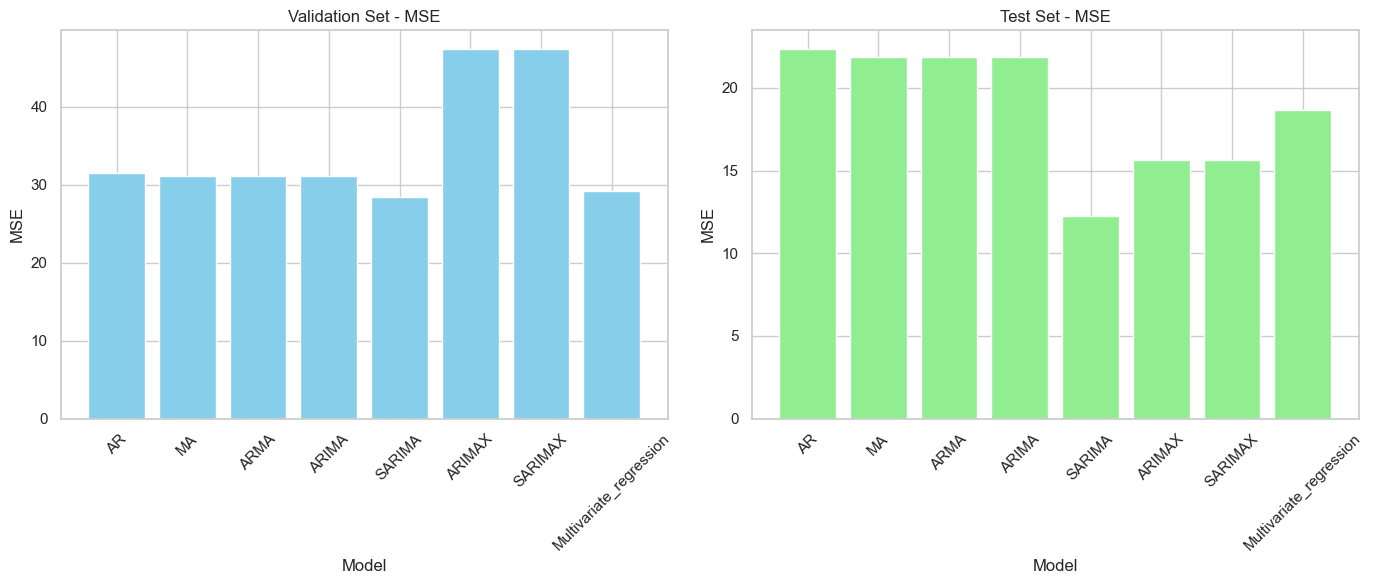

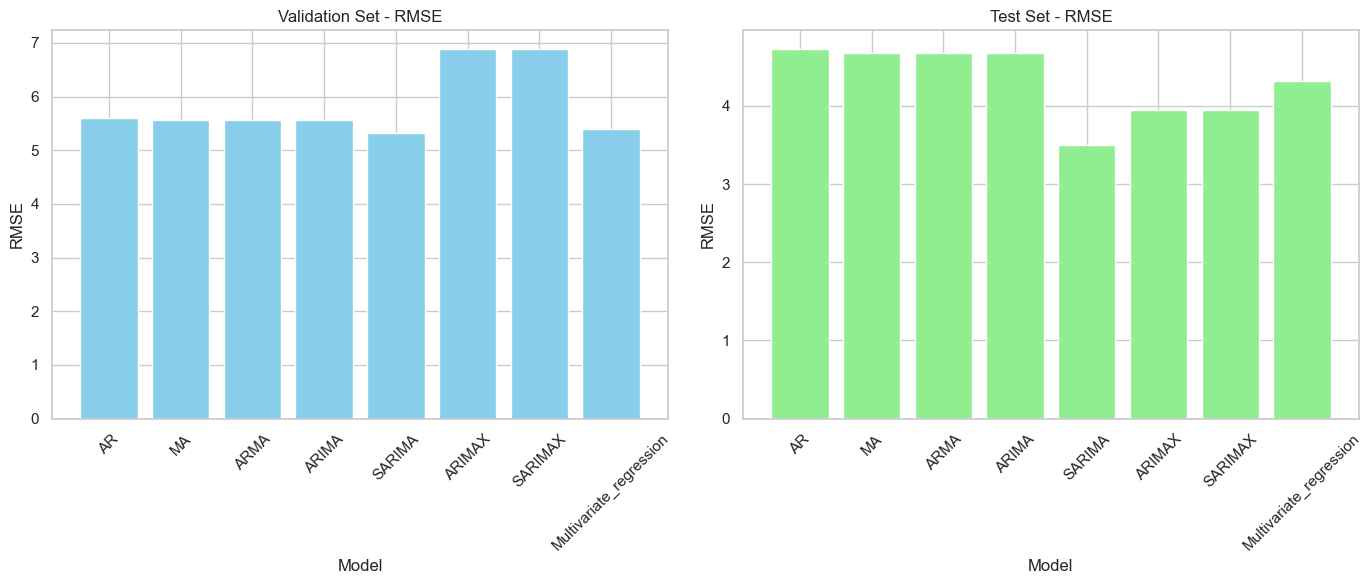

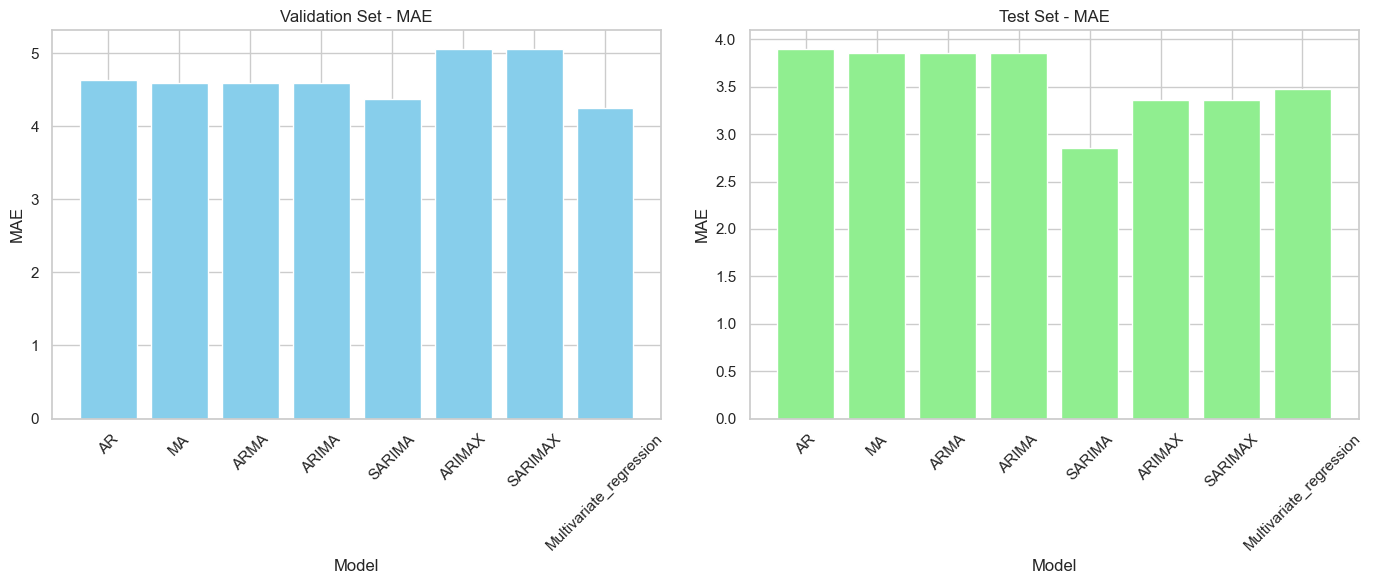

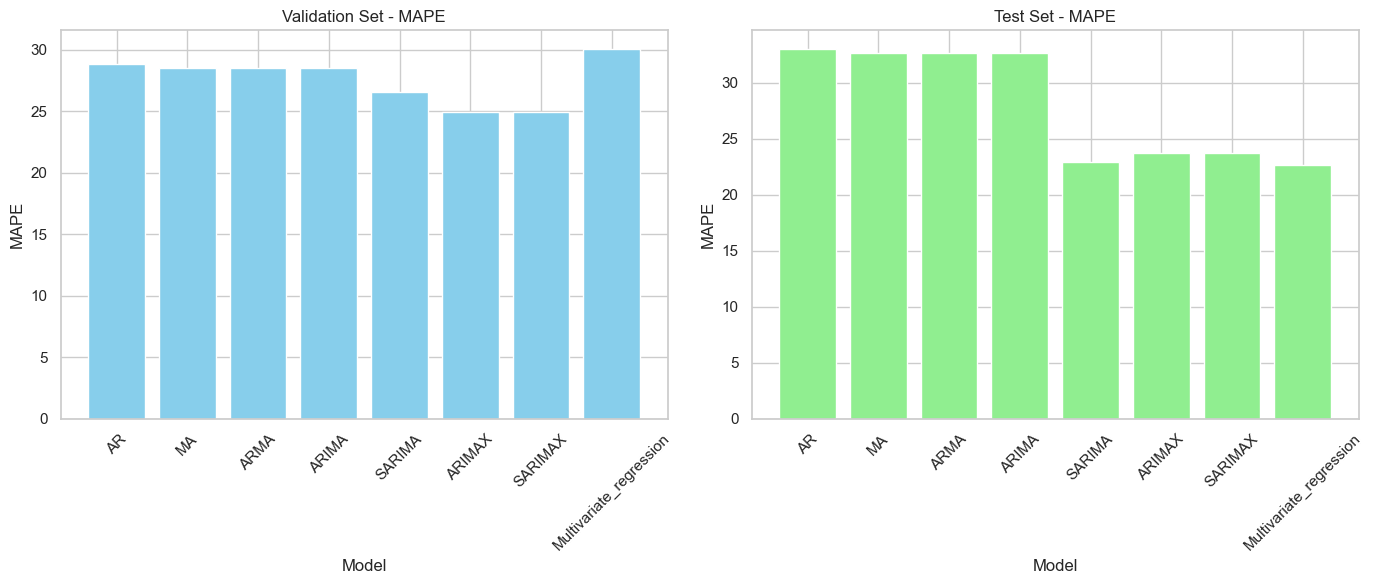

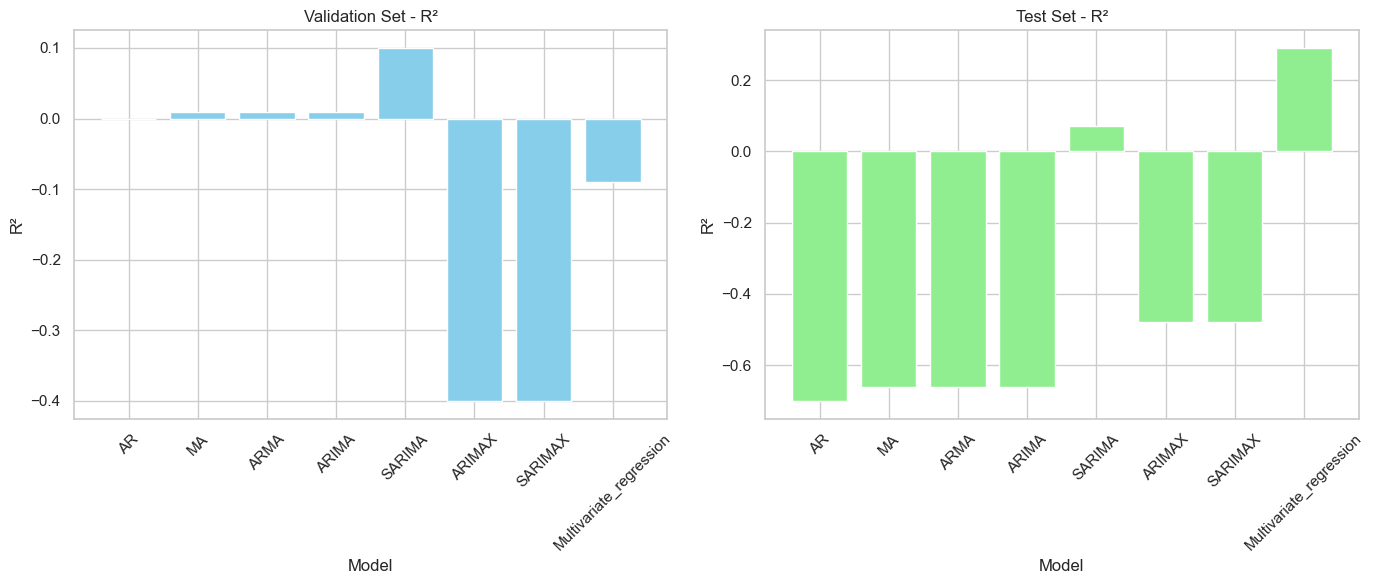

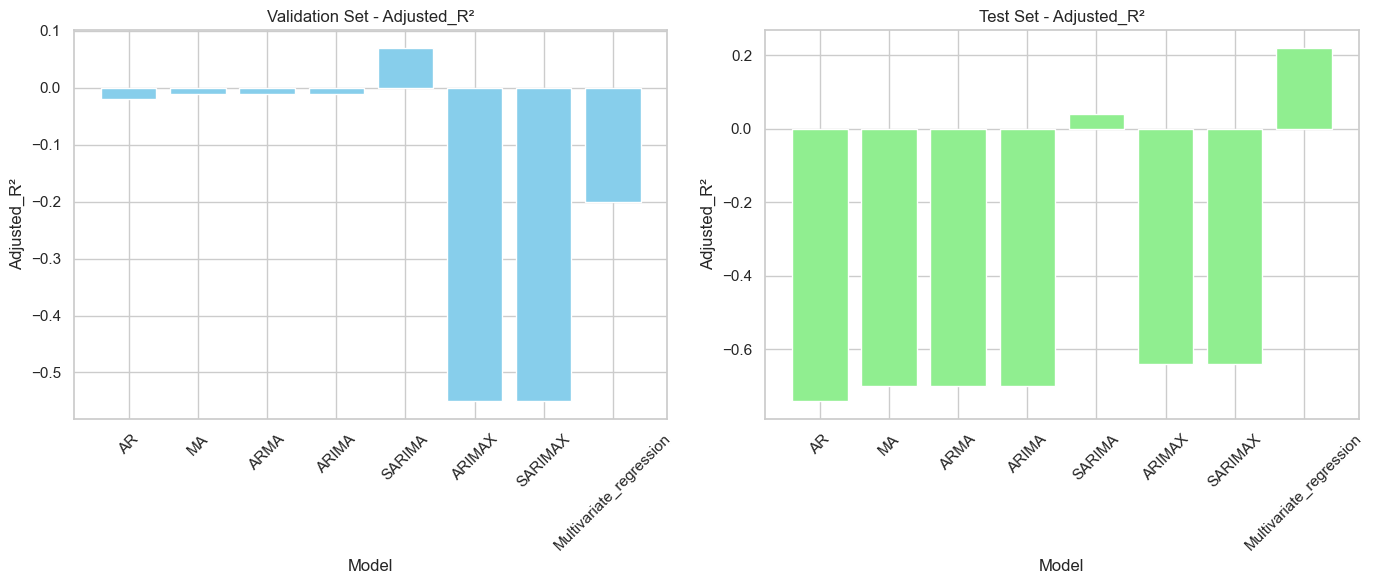

The best model to predict is Multivariate_regression with the lowest MAPE of 22.61 on the test set.
SARIMA is consistently the best across all metrics in both validation and test sets.


In [51]:
file_path = 'time_series_model_comparison.xlsx'
excel_data = pd.ExcelFile(file_path)
validation_data = pd.read_excel(file_path, sheet_name='Validation Set Metrics')
test_data = pd.read_excel(file_path, sheet_name='Test Set Metrics')
def plot_metrics_comparison(validation_data, test_data, metric):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.bar(validation_data['Model'], validation_data[metric], color='skyblue')
    plt.title(f'Validation Set - {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.subplot(1, 2, 2)
    plt.bar(test_data['Model'], test_data[metric], color='lightgreen')
    plt.title(f'Test Set - {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
metrics = ['MSE', 'RMSE', 'MAE', 'MAPE', 'R²', 'Adjusted_R²']
for metric in metrics:
    plot_metrics_comparison(validation_data, test_data, metric)
best_model_row = test_data.loc[test_data['MAPE'].idxmin()]
best_model = best_model_row['Model']
best_mape = best_model_row['MAPE']
print(f"The best model to predict is {best_model} with the lowest MAPE of {best_mape:.2f} on the test set.")
print("SARIMA is consistently the best across all metrics in both validation and test sets.")

MSE (Train): 0.08
MSE (Test): 0.08
MAE (Train): 0.24
MAE (Test): 0.24


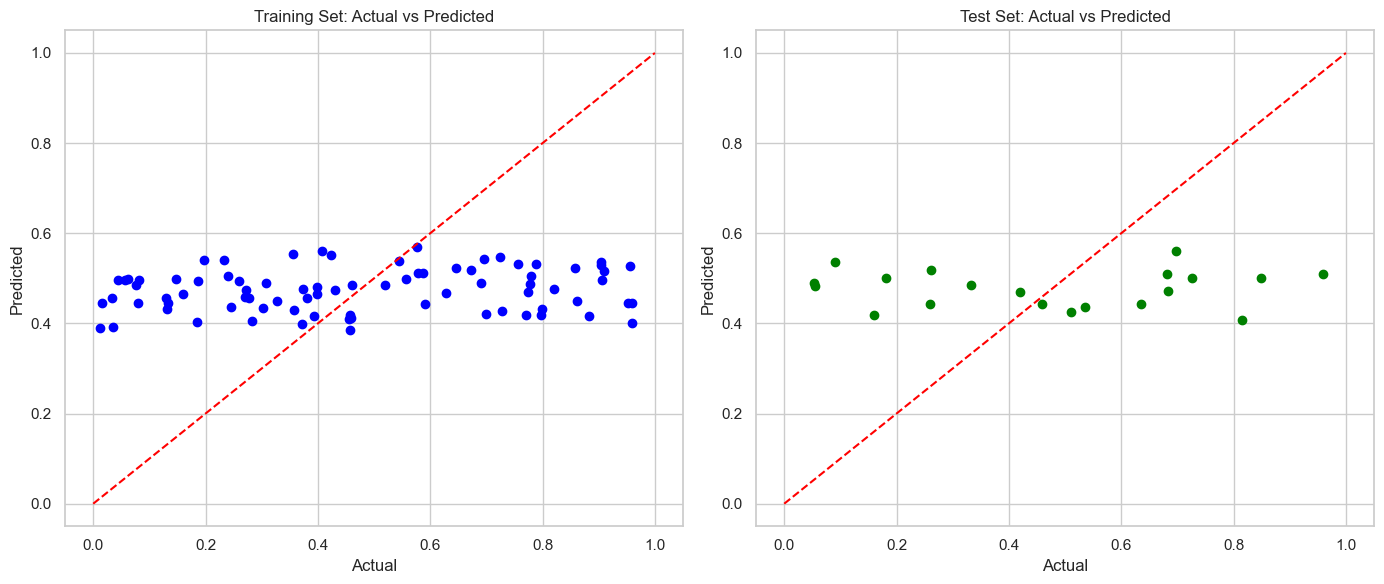

In [52]:
np.random.seed(0)
example_data = pd.DataFrame({
    'Feature1': np.random.rand(100),
    'Feature2': np.random.rand(100),
    'Feature3': np.random.rand(100),
    'Target': np.random.rand(100)
})
X = example_data[['Feature1', 'Feature2', 'Feature3']]
y = example_data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'MSE (Train): {mse_train:.2f}')
print(f'MSE (Test): {mse_test:.2f}')
print(f'MAE (Train): {mae_train:.2f}')
print(f'MAE (Test): {mae_test:.2f}')
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, color='blue')
plt.plot([0, 1], [0, 1], '--', color='red')
plt.title('Training Set: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_test, color='green')
plt.plot([0, 1], [0, 1], '--', color='red')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()